# Introducción
El objetivo final de la práctica es predecir el precio de las viviendas de AirBnB de la ciudad de Madrid a partir de un dataset que se encuentra [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&q=Madrid&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B), así como establecer una relación general entre las imágenes de las viviendas y su precio. Sólo se procesarán las viviendas que tengan un precio asignado, así como imágenes que puedan ser examinadas y analizadas.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Cargamos el dataset en Google Colab
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2020-06-24 07:04:48--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.248.20.69, 34.249.199.226
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [       <=>          ]  54.19M   701KB/s    in 98s     

2020-06-24 07:06:32 (567 KB/s) - ‘airbnb-listings.csv’ saved [56826824]



In [ ]:
# Verificamos que se ha cargado el archivo
!ls -la 

total 55512
drwxr-xr-x 1 root root     4096 Jun 24 07:04 .
drwxr-xr-x 1 root root     4096 Jun 24 06:59 ..
-rw-r--r-- 1 root root 56826824 Jun 24 07:06 airbnb-listings.csv
drwxr-xr-x 1 root root     4096 Jun 19 16:15 .config
drwxr-xr-x 1 root root     4096 Jun 17 16:18 sample_data


# 1. Librerías principales, opciones y funciones generales

## 1.1 Librerías principales y opciones

In [ ]:
# Librerías más usadas a lo largo del notebook. 
import numpy as np
import pandas as pd
import imageio as io
import cv2
from tqdm import tqdm  # necesario para  mostrar el progreso en algunos procesos

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
import warnings
warnings.filterwarnings('ignore')

# Por defecto mostramos todas las columnas y filas de los datasets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## 1.2 Funciones generales
Funciones que se va a utilizar varias veces a lo largo del notebook. También se evita la repetición de la declaración de arrays. Estás funciones se sitúan al principio del notebook porque es más fácil localizarlas cuando se está desarrollando el código.

In [ ]:
def get_non_essential_columns():
    return  ['ID','Listing Url','Scrape ID'
        , 'Thumbnail Url','Medium Url','Picture Url','XL Picture Url'
        , 'Host URL','Host Thumbnail Url','Host Picture Url'
        , 'Last Scraped','Name','Summary','Space','Description'
        , 'Neighborhood Overview','Notes','Transit','Access'
        , 'Interaction','House Rules','Host Name'
        , 'Host ID','Host About','Host Listings Count'
        , 'Host Total Listings Count','Calculated host listings count'
        , 'Host Location','Host Neighbourhood','Weekly Price','Monthly Price'
        , 'Calendar Updated','Calendar last Scraped','First Review'
        , 'Last Review','Reviews per Month'
    ]

In [ ]:
def get_not_madrid(df):
    return df[(df['City'] != "Madrid") & (df['City'] != "MADRID") ].index

In [ ]:
def get_columns_with_missing_values():
    return ['Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names']

In [ ]:
def get_redundant_columns():
    return ['Geolocation', 'State', 'Market', 'Smart Location'
     , 'Country', 'Country Code', 'Street', 'Zipcode', 'Neighbourhood'
     , 'Neighbourhood Group Cleansed','City']

In [ ]:
def get_correlated_columns():
    return ['Accommodates', 'Availability 30', 'Availability 60'
            , 'Availability 90', 'Review Scores Rating', 'Review Scores Accuracy'
            , 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication'
            , 'Review Scores Location']

In [ ]:
def remove_numeric_outliers(df_outliers):
    df = df_outliers[(df_outliers['Price'] <= 300)] # Se borran también los valores nulo
    df = df[(df['Security Deposit'] <= 650) | (df['Security Deposit'].isnull())]
    df = df[(df['Cleaning Fee'] <= 150) | (df['Cleaning Fee'].isnull())]
    df = df[(df['Extra People'] <= 50) | (df['Extra People'].isnull())]
    df = df[(df['Minimum Nights'] <= 365) | (df['Minimum Nights'].isnull())]
    df = df[(df['Maximum Nights'] <= 1125) | (df['Maximum Nights'].isnull())]
    return df

In [ ]:
def fillna_with_zero(df):
    df['Security Deposit'].fillna(0, inplace=True)
    df['Cleaning Fee'].fillna(0, inplace=True)
    df['Host Response Rate'].fillna(0, inplace=True)
    return df

In [ ]:
# Se almacenan en variables intermedias las medias para no tener
# que hacer que calcular dichas medias más de una vez (cada vez
# que tiene que ser procesado un dataset de test).
# Esta misma política de guardar variables intermedias se realiza en siguientes
# funciones a lo largo del notebook.
mean_Bathrooms = 0
mean_Bedrooms = 0
mean_Beds = 0
mean_Review_Scores_Value = 0

# Esta función podría recibir el dataframe que queremos actualizar y
# el dataframe de train, pero ello exigiría volver a calcular las medias.
# Es más rápido y con menor coste de CPU utilizar las medias previamente
# calculadas y almancenadas en variables intermedias de trabajo.
def fillna_with_means(df, mean_Bathrooms, mean_Bedrooms, mean_Beds
    , mean_Review_Scores_Value):
    df['Bathrooms'].fillna(mean_Bathrooms, inplace=True)
    df['Bedrooms'].fillna(mean_Bedrooms, inplace=True)
    df['Beds'].fillna(mean_Beds, inplace = True)
    df['Review Scores Value'].fillna(mean_Review_Scores_Value, inplace = True)
    
    return df

In [ ]:
def dropna_in_host_since(df_host_since) :
    df = df_host_since.dropna(subset=['Host Since'])
    return df

In [ ]:
def fillna_with_empty_string(df):
    df['Host Verifications'].fillna("", inplace=True)
    df['Amenities'].fillna("", inplace=True)
    df['Features'].fillna("", inplace=True) # esta caso no haría falta, pero se pone por si aparece un dataset,
                                            # en el que sí haga falta
    return df 

In [ ]:
mode_Host_Response_Time=""
def fillna_Host_Response_Time_with_its_mode(df, mode_Host_Response_Time):
    df['Host Response Time'].fillna(mode_Host_Response_Time, inplace=True)
    return df

In [ ]:
def get_empty_columns():
    return ['Experiences Offered']

In [ ]:
mean_price_map = {}
overall_mean_price = 0
def get_categorical_variables():
    return ['Host Response Time', 'Neighbourhood Cleansed', 'Property Type'
                         , 'Room Type', 'Bed Type', 'Cancellation Policy']

In [ ]:
def mean_encoding_to_categorical_variables(df, mean_price_map, overall_mean_price):
    for var in get_categorical_variables():
        # Media de precio por variable categórica
        df[var] = df[var].map(mean_price_map[var])
        # Si hay una variable categórica que no existe en el mapa, asignamos precio medio
        df[var].fillna(overall_mean_price, inplace=True)

    return df

In [ ]:
def count_elements_in_list(df_lists):
    lists = ['Amenities', 'Features', 'Host Verifications']
    for l in lists:
        df_lists[l] = df_lists[l].apply(lambda x: len(str(x).split(',')))
        
    return df_lists

In [ ]:
from datetime import datetime
def calculate_years(df_cy):
    current_year = int(datetime.now().year)
    df_cy['Host Since'] = df_cy['Host Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    df_cy['Years'] = df_cy['Host Since'].apply(lambda x: current_year - x.year)
    df_cy.drop(['Host Since'], axis=1, inplace=True) # Borramos la columna de Host Since

    return df_cy

In [ ]:
# En esta función están todas las operaciones que se deben ejecutar al dataset 
# de test, en el mismo orden y modo que se han realizado previamente al dataset
# de train. Esta función se ejecutará sobre el dataset de test antes de realizar
# la validación del modelo.
def drop_columns_and_filter_rows_in_test_set(df_test 
    , mean_Bathrooms, mean_Bedrooms, mean_Beds, mean_Review_Scores_Value
    , mode_Host_Response_Time, mean_price_map, overall_mean_price):
    
    # Eliminar columnas no esenciales
    dfx = df_test.drop(get_non_essential_columns(), axis=1)
    # Filtrar Madrid
    dfx.drop(get_not_madrid(dfx), axis=0, inplace=True)
    
    # Eliminar columnas con muchos valores missing
    dfx.drop(get_columns_with_missing_values(), axis=1, inplace=True)

    # Eliminar columnas redundantes
    dfx.drop(get_redundant_columns(), axis=1, inplace=True)
    
    # Eliminar columnas correlacionadas
    dfx.drop(get_correlated_columns(), axis=1, inplace=True)

    # Ponemos la columna precio la primera
    cols = dfx.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Price')))
    dfx = dfx[cols]
    
    # Eliminar outlier de columnas numéricas
    dfx =  remove_numeric_outliers(dfx)
    
    # Rellenar NaNs con 0
    dfx = fillna_with_zero(dfx)

    # Rellenar NaNs con medias
    dfx = fillna_with_means(dfx
      , mean_Bathrooms, mean_Bedrooms, mean_Beds, mean_Review_Scores_Value)
    
    # Eliminar filas con Host Since nulo
    dfx = dropna_in_host_since(dfx)
    
    # Rellenar nulos con cadenas vacías en determinadas columnas que tienen listas
    # de valores separados por comas
    dfx = fillna_with_empty_string(dfx)
    
    # Rellenar con la moda los valores nulos de Host_Response_Time 
    dfx = fillna_Host_Response_Time_with_its_mode(dfx, mode_Host_Response_Time)
    
    # Borrar las columnas string (object) con muchos valores vacíos o equivalente
    dfx = dfx.drop(get_empty_columns(), axis=1)

    # Asignar precios medios por categoría
    dfx = mean_encoding_to_categorical_variables(dfx
      , mean_price_map, overall_mean_price)  
    
    # Sustituir columnas con listas de valores por el número de elementos que hay en la lista
    dfx = count_elements_in_list(dfx)
    
    # Calcular los años de antigüedad que lleva la vivienda en Airbnb
    dfx = calculate_years(dfx)
    
    return dfx
    

In [ ]:
def create_labels(dfx):
  y_class = []
  y_reg = dfx['Price']
  for x in y_reg:
      if x <= 50: # barato
          y_class.append(0)
      elif x <=150: # normal
          y_class.append(1)
      else: # caro
          y_class.append(2)
  return y_class

# 2. Carga de datos. Eliminación de características innecesarias.
## 2.1 Carga de datos y características básicas


In [ ]:
data = pd.read_csv('airbnb-listings.csv', sep = ';')

## 2.2 Inspección básica

In [ ]:
data.head(5).T

,0,1,2,3,4
ID,12768616,1629146,4539828,15698134,15447205
Listing Url,https://www.airbnb.com/rooms/12768616,https://www.airbnb.com/rooms/1629146,https://www.airbnb.com/rooms/4539828,https://www.airbnb.com/rooms/15698134,https://www.airbnb.com/rooms/15447205
Scrape ID,20170407214050,20170407214050,20170407214050,20170407214050,20170407214050
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Ramblas Studio D,"Design, art & vintage / old city",Penthouse with terrace in Rambla Catalunya -Ce...,130. Hércules Pequeño 41,Sagrada Familia Apartment E
Summary,"Unique apartment in vibrant neighborhoods, car...","If you're looking for a cool, spacious, light,...",For perfect relaxing time with friend or famil...,"Unique apartment in vibrant neighborhoods, car...","Unique apartment in vibrant neighborhoods, car..."
Space,Centrally located in the atmospheric Gothic Qu...,The apartment is very comfortable and very tas...,This very beautiful and bright apartment is lo...,New apartment just meters from the Basilica of...,Occupying the picturesque avenues of the Eixam...
Description,"Unique apartment in vibrant neighborhoods, car...","If you're looking for a cool, spacious, light,...",For perfect relaxing time with friend or famil...,"Unique apartment in vibrant neighborhoods, car...","Unique apartment in vibrant neighborhoods, car..."
Experiences Offered,none,none,none,none,none
Neighborhood Overview,Located on the edge of the Gothic Quarter of B...,• A major advantage of this apartment is its l...,"Located in the real center of the city, close ...",NaN,NaN


In [ ]:
# Comprobamos el tamaño de nuestro dataset
data.shape

(14001, 89)

In [ ]:
# comprobamos si hay viviendas con precio nulo
data['Price'].isna().sum()

11

In [ ]:
# Borramos filas con precio nulo, ya que, evidentemente, para nuestro estudio lo consideraremos como un error
data.dropna(subset=['Price'], inplace=True)

In [ ]:
# comprobamos de nuevo si hay viviendas con precio nulo
data['Price'].isna().sum()

0

In [ ]:
data.shape

(13990, 89)

In [ ]:
# Analizamos algunas columnas con url de imágenes
print(data['Thumbnail Url'][0])
print(data['Medium Url'][0])
print(data['Picture Url'][0])
print(data['XL Picture Url'][0])
print(data['Host URL'][0])

https://a0.muscache.com/im/pictures/cffe393a-0d84-4fd5-ab4c-a62e067c1b0d.jpg?aki_policy=small
https://a0.muscache.com/im/pictures/cffe393a-0d84-4fd5-ab4c-a62e067c1b0d.jpg?aki_policy=medium
https://public.opendatasoft.com/api/v2/catalog/datasets/airbnb-listings/files/543332f657ad52e151198789ca87d146
https://a0.muscache.com/im/pictures/cffe393a-0d84-4fd5-ab4c-a62e067c1b0d.jpg?aki_policy=x_large
https://www.airbnb.com/users/show/54310958


Como se puede observar, la url Tumbnail, Medium y XL son iguales, pero con distinto tamaño. Por simplicidad, y ahorro computacional vamos a elegir la imagen Thumbnail. 

La columna *Picture Url* es para descargar un archivo, que exigiría un tratamiento posterior, el cual está fuera del alcance de esta práctica. Asimismo, se considera que está fuera del alcance de esta práctica el análisis de las imágenes que se podrían obtener de la página web indicada en la columna *Listing Url*.

Por último, las imágenes del dueño (Host) no son relevantes para deducir el precio de la vivienda.

## 2.2 Carga inicial de imágenes
En este epígrafe cargaremos en memoria las imágenes de Thumbnail, bien desde archivos que previamente tengamos almacenados en GDrive o, en caso contrario, descargándolas desde internet con las urls que están en el dataset. Los dos primeros subepígrafes son excluyentes entre sí: el primero es para leer datos de GDrive y el segundo para leer las imágenes de innternet.

Una vez cargadas las imágenes, filtraremos el dataframe de Airbnb y sólo nos quedaremos con las filas que tengan imágenes de Thumbnail.


### 2.2.1 Carga de imágenes desde GDrive

Si ya tenemos los datos almacenados previamente en GDrive, ejecutaremos la sentencias de este epígrafe; en caso contrario, ejecutaremos las del siguiente epígrafe

In [ ]:
# Leemos los datos directamente del GDrive
loaded_images = np.load('/content/drive/My Drive/images.npy')
was_loaded = np.load('/content/drive/My Drive/was_loaded.npy')
print(loaded_images.shape)
print(was_loaded.shape)

(13990, 224, 224, 3)
(13990,)


### 2.2.2 Descarga de imágenes y almacenamiento en GDrive

En este epígrafe descargaremos las imágenes Thumbnail de las urls que se se indican en el dataset y, posteriormente, las almacenaremos en GDrive. Esta sección no se debe ejecutar si previamente ya tenemos las imágenes almacenadas en GDrive


In [ ]:
# Aquí creamos nuestra estructura de datos, que va a consistir en la url de la
# imagen y un índice para saber donde insertarla en nuestro array
images_paths = [[i, img_url] for i, img_url in enumerate(data['Thumbnail Url'])]

In [ ]:
# Analizamos las primera filas
images_paths[:5]

[[0,
  'https://a0.muscache.com/im/pictures/cffe393a-0d84-4fd5-ab4c-a62e067c1b0d.jpg?aki_policy=small'],
 [1,
  'https://a0.muscache.com/im/pictures/ea919e56-aa99-4d5d-a129-1edf0d117d6a.jpg?aki_policy=small'],
 [2,
  'https://a0.muscache.com/im/pictures/57011236/eea5c213_original.jpg?aki_policy=small'],
 [3,
  'https://a0.muscache.com/im/pictures/974f0245-55c2-4e8c-b9bf-14c1c975c798.jpg?aki_policy=small'],
 [4,
  'https://a0.muscache.com/im/pictures/c2dde263-20dd-43af-8c6b-be636c2c0ce1.jpg?aki_policy=small']]

In [ ]:
# Si no tenemos alamcenados los datos previamente, ejecutamos el siguiente código
# de esta sección

# Creamos la siguiente función específicacon la que se descargará la imagen y 
# devolverá la imagen y el índice indicando la posición donde se incrustará la
# imagen en nuestro array
def get_image(data_url, target_size=(224, 224)):
    idx, url = data_url
    try:
        img = io.imread(url)
        # hay alguna imagen en blanco y negro y daría error al incluirla en 
        # nuestro array de imagenes que tiene 3 canales, así que convertimos
        # todas las imágenes que tengan menos de 3 dimensiones a color
        if img.ndim < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, dsize=target_size)
        return img, idx
    except IOError as err:
        return (None, idx)

In [ ]:
# En este array se incrustanrán las imágenes conforme se vayan obteniendo
loaded_images = np.zeros((len(images_paths), 224, 224, 3), dtype=np.uint8)

# y en este array se lleva un control de cuáles se han cargado correctamente
# y cuáles no
was_loaded = np.zeros(len(images_paths))

In [ ]:
# Verificamos dimensiones
print(loaded_images.shape)

(13990, 224, 224, 3)


In [ ]:
# Proceso de carga de imágenes. Este proceso tarda bastantes minutos.

import concurrent

# Se crea un pool de procesos que descargarán las imágenes.
# Por defecto, se crearán tantos como CPUs tenga vuestra máquina
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Se procesa la lista de urls de imágenes paralelizándola con el pool de procesos
    for (img, idx) in tqdm(executor.map(get_image, images_paths), total=len(images_paths)):
        # metemos la imagen en nuestro array
        if img is not None:
            loaded_images[idx] = img
            was_loaded[idx] = 1
        else:
            was_loaded[idx] = 0

print('Terminado')
print(f'Total de imágenes recuperadas correctamente: {sum(was_loaded)}/{len(images_paths)}')

100%|██████████| 13990/13990 [16:01<00:00, 14.55it/s]


Terminado
Total de imágenes recuperadas correctamente: 11266.0/13990


In [ ]:
# Para evitar repetir la lectura de las imágenes, se guardan en GDrive con el
# de recuperarlas directamente
np.save('images.npy', loaded_images)
np.save('was_loaded.npy', was_loaded)

In [ ]:
# Montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Almacenamos las imagenes en nuestro drive
!cp images.npy /content/drive/My\ Drive/images.npy
!cp was_loaded.npy /content/drive/My\ Drive/was_loaded.npy

In [ ]:
# Verificamos que se han guardado los archivos
# Verificamos que se ha cargado el archivo
!ls -la /content/drive/My\ Drive

total 2101717
-r-------- 1 root root        151 Jan 10 22:49 'Big Data Architecture - Practica.gdoc'
drwx------ 2 root root       4096 Dec 16  2019 'Colab Notebooks'
-rw------- 1 root root   46149760 Jun 21 17:05  images_feat.npy
-rw------- 1 root root 2105886848 Jun 22 08:27  images.npy
drwx------ 2 root root       4096 Jun 18 13:26  KeepCoding
-rw------- 1 root root     112048 Jun 22 08:27  was_loaded.npy


### 2.2.3 Datos con solo imágenes
En este epígrafe creamos el dataframe definitivo con el que se va a trabajar en el que todas las viviendas tienen imagen de thumbnail. También almancenaremos un array con la imagen en memoria de cada vivienda.

In [ ]:
# Comprobamos cuántas imágenes realmente ha podido ser cargadas
unique, counts = np.unique(was_loaded, return_counts=True)
dict(zip(unique, counts))

{0.0: 2724, 1.0: 11266}

El número de imágenes cargadas es de 11.266, por lo tanto, vamos a crear un dataframe con 11266 viviendas y una array con las 11266 imágenes

In [ ]:
data_with_images = data[was_loaded == 1]
images = loaded_images[was_loaded == 1]

In [ ]:
# verificamos los tamaños
print(data_with_images.shape, images.shape)

(11266, 89) (11266, 224, 224, 3)


In [ ]:
data_with_images.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,12768616,https://www.airbnb.com/rooms/12768616,20170407214050,2017-04-08,Ramblas Studio D,"Unique apartment in vibrant neighborhoods, car...",Centrally located in the atmospheric Gothic Qu...,"Unique apartment in vibrant neighborhoods, car...",none,Located on the edge of the Gothic Quarter of B...,NaN,The nearest station is Place de Catalunya a fe...,NaN,NaN,No pets or smoking allowed.,https://a0.muscache.com/im/pictures/cffe393a-0...,https://a0.muscache.com/im/pictures/cffe393a-0...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/cffe393a-0...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.383887,2.171802,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,349.0,NaN,NaN,NaN,NaN,1,0,2,1125,a week ago,NaN,2,2,2,2,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,92,NaN,"41.3838872822,2.17180232785","Host Has Profile Pic,Host Identity Verified,Is..."
1,1629146,https://www.airbnb.com/rooms/1629146,20170407214050,2017-04-08,"Design, art & vintage / old city","If you're looking for a cool, spacious, light,...",The apartment is very comfortable and very tas...,"If you're looking for a cool, spacious, light,...",none,• A major advantage of this apartment is its l...,• Possibility of offering Premium Services suc...,• Nearest metro station is 1 min walk (Sant A...,Here's a list of of things we provide to our g...,==============================================...,* NO parties are allowed * NO noise on the st...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ea919e56-a...,8658841,https://www.airbnb.com/users/show/8658841,Olga & Co.,2013-09-05,"Barcelona, Catalonia, Spain","World traveller, currently living and working ...",within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/d67fdad1-e...,https://a0.muscache.com/im/pictures/d67fdad1-e...,El Raval,2.0,2.0,"email,phone,reviews,jumio","El Raval, Barcelona, Catalonia 08001, Spain",El Raval,el Raval,Ciutat Vella,Barcelona,Catalonia,08001,Barcelona,"Barcelona, Spain",ES,Spain,41.382663,2.167558,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"TV,Internet,Wi

Como se puede comprobar, tanto el dataframe , como el array tienen los 11266 previstos. **A partir de este momento, se utilizarán a lo largo de este notebook ambas variables, *images* y *data_with_images*, como fuente de datos. Se establece como restricción para la predicción del precio la premisa de que la vivienda de Airbnb tenga una imagen de Thumbnail y un precio** 

In [ ]:
# Hacemos un dtype para saber los tipos de cada columna
data_with_images.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

# 3 Análisis exploratorio de datos (EDA). Exploraty Data Analysis

En primer lugar vamos a dividir el dataframe en train y test. El conjunto de datos de test NO lo utilizaremos en ningún momento a lo largo del análisis, excepto al final del proceso, para validar los modelos que se obtengan. Inicialmente se va a realizar todo el proceso sin tener en cuenta las imágenes, ya que se analizarán más adelante.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_with_images, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
df = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (9012, 89)
Dimensiones del dataset de test: (2254, 89)


## 3.1 Eliminación de características no esenciales

En este proceso vamos a eliminar columnas, pero previamente analizaremos superficialmente su contenido. Algunas de ellas serán eliminadas en un primer estudio que se hace en esta práctica, pero más adelante podrían ser recuperadadas y ser analizadas para incorporarlas, si fueran interesantes, a los modelos. 

In [ ]:
df.head().T

,0,1,2,3,4
ID,17631598,15549757,13651164,18070933,12695064
Listing Url,https://www.airbnb.com/rooms/17631598,https://www.airbnb.com/rooms/15549757,https://www.airbnb.com/rooms/13651164,https://www.airbnb.com/rooms/18070933,https://www.airbnb.com/rooms/12695064
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170315084710
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-03-15
Name,Brand-new 1BD - GRAN VIA,Habitation en el Centro de Madrid-Malasaña,Cozy Apartment Madrid,Apartamento Madrid Centro,Preciosa casa en el corazón de Valldemossa
Summary,Comfortable and bright apartment in the center...,Habitación individual luminosa y silenciosa en...,Lugares de interés: Mercado de Santa María de ...,Estudio capacidad para dormir 4 personas. Pose...,"La casa está distribuida en tres plantas, con ..."
Space,Comfortable and bright apartment in the center...,"Cocina totalmente equipada con microondas, vit...",NaN,NaN,Es una casa muy acogedora y con una decoración...
Description,Comfortable and bright apartment in the center...,Habitación individual luminosa y silenciosa en...,Lugares de interés: Mercado de Santa María de ...,Estudio capacidad para dormir 4 personas. Pose...,"La casa está distribuida en tres plantas, con ..."
Experiences Offered,none,none,none,none,none
Neighborhood Overview,Located in a dynamic and central neighborhood ...,El barrio es el más céntrico de Madrid y tiene...,Inmejorable,La Latina,Ubicado en La Serra de Tramuntana (Patrimonio ...


Revisando los valores de las columnas vemos que algunos valores de las mismas no aportan información relacionada con el precio. Podríamos agruparlos del siguiente modo:
- Identificadores
- URLs que nos van a ser estudiadas. Previamente ya hemos obtenido imágenes de Thumbnail Url, pero a partir de ese momento, esta columna ya no hace falta.
- Valores de fecha que no están relacionados con el precio
- Columnas de tipo texto/descripción que exigirían la utilización de palabras clave (habría que recurrir a taxonomías y ontologías) para poder obtener a partir de ellas características nuevas. También algunos campos podrían ser analizamos mediante técnicas NLP. Algunas de estas columnas podrían ser recuperadas y analizadas de nuevo después de realizar el módulo de NLP del presente Bootcamp. En este momento se considera fuera de alcance por falta de conocimiento. En un entorno real de trabajo habría que considerarlas, ya que estas columnas podrían ofrecer información a través de su contenido de forma directa, aplicando las correspondiente técnicas.
<div class = "alert alert-success">
TODO: En el caso de las solución por palabras clave, podría ser parte del código que desarrolláramos el de la función getExpensiveWords que se encuentra <a href="https://github.com/peternmai/Airbnb_Price_Prediction/blob/master/AirBnB%20Price%20Prediction.ipynb" target="_blank">aquí</a>, y que relaciona cada palabra con el precio.
</div>
- Hay columnas cuyo contenido es redundante con repecto a otras columnas


En este sentido, las columnas que creemos que se deben borrar son:
- ID: no está relacionado con el precio, ya que no indica nada sobre la vivienda
- Listing Url
- Scrape ID:  no está relacionado con el precio, ya que no indica nada sobre la vivienda
- Thumbnail Url: ya hemos cargado las imágenes proporcionadas en esta url
- Medium Url: son imágenes similares a la de Thumbnail, pero a mayor escala. En futuros estudios podría ser utilizada.
- Picture Url: hay que descargar archivos. En futuros estudios podría ser utilizada.
- XL Picture Url: son imágenes similares a la de Thumbnail, pero a mayor escala. En futuros estudios podría ser utilizada.
- Host Url: no parte nada la url del dueño.
- Host Thumbnail Url: no aporta nada la imagen del dueño.
- Host Picture Url: no aporta nada la imagen del dueño.
- Last Scraped: la fecha en el que se hizo el scrape no está relacionada con el precio
- Name: el nombre no aporta información respecto al precio, o al menos exigiría tokenización
- Summary: exige tokenización y/o NLP
- Space: exige tokenización y/o NLP
- Description: exige tokenización y/o NLP
- Neighborhood Overview: exige tokenización y/o NLP
- Notes: exige tokenización y/o NLP
- Transit: exige tokenización y/o NLP
- Access: exige tokenización y/o NLP
- Interaction: exige tokenización y/o NLP
- House Rules: exige tokenización y/o NLP
- Host Name: no aporta información. Tal vez de algún estudio de marketing podría deducirse que un nombre llama más la atención que otro. En el caso de ser el nombre del dueño no aporta mucho. Hay otros datos del dueño, como Host Since, que aportan más información.
- Host ID: al igual que el nombre, el identificador del dueño no es relevante respecto al precio de la vivienda
- Host About: exige tokenización y/o NLP
- Host Listings Count: número de viviendas ofrecidas por el mismo dueño. Tal vez, en estudio posterior, se podría analizar si el mismo dueño rebaja el precio cuando tiene muchas viviendas, aunque no tendría por qué ser así. Descartamos esta columna.
- Host Total Listings Count: parece tener la misma información que la columna anterior. También la descartamos.
- Calculated host listings count: información relacionada con el dueño similar a las dos columnas anteriores. Se elimina.
- Host Location: es información redundante con otras columnas
- Host Neighbourhood: no aporta información el barrio del dueño.
- Weekly Price: puede ser un precio deducible o derivado del precio diario. Lo ignoramos por redundate.
- Monthly Price: puede ser un precio deducible o derivado del precio diario. Lo ignoramos por redundate.
- Calendar Updated: no tiene valor para predecir el precio
- Calendar last Scraped: lo eliminamos por la misma razón que Last Scraped
- First Review: no aporta información
- Last Review: igual que First Review
- Reviews per Month: no afecta al precio de la vivienda

In [ ]:
df.drop(get_non_essential_columns(), axis=1, inplace=True)

In [ ]:
df.shape

(9012, 53)

##  3.2 Filtrar filas

Como se ha mencionado, el objetivo principal es predecir el precio de vivienda de la ciudad de Madrid. Vamos a analizar la columna City.

In [ ]:
df['City'].value_counts()

Madrid                             8523
Barcelona                           182
马德里                                  35
Alcúdia                              27
Palma                                25
Madrid, Comunidad de Madrid, ES      14
Inca                                 11
Selva                                 8
Deià                                  7
Pollença                              7
Palma de Mallorca                     7
Valldemossa                           5
Manacor                               5
Pollensa                              5
Campanet                              5
madrid                                5
Sóller                                5
Muro                                  5
Santa Margalida                       4
Pozuelo de Alarcón                    4
Sineu                                 3
Santanyí                              3
Can Picafort                          3
Búger                                 3
Petra                                 3


Como se puede observar la gran mayoría de registros pertenecen a la ciudad de Madrid, y el resto pertenecen a otras ciudades con un número de elementos muy pequeño, lo cual impide la posibilidad de predecir el precio de la vivienda en dichas ciudades. Así pues, se decide solo seleccionar los registros cuya ciudad sea Madrid o MADRID. Esta decisión también se tomó en módulos anteriores del Bootcamp.

In [ ]:
df.drop(get_not_madrid(df), axis=0, inplace=True)

In [ ]:
df.shape

(8525, 53)

In [ ]:
df['City'].value_counts()

Madrid    8523
MADRID       2
Name: City, dtype: int64

## 3.3 Análisis de valores missing

En este apartado analizaremos aquellas columnas que tienen muchos datos vacíos y, por tanto, de las que no podamos obtener información. Para realizar este análisis utilizaremos la función df.count(), mediante la cual obtenemos el total de valores distintos de None (valor nulo) que tiene cada columna. Vamos a calcular de cada columna el número de nulos simplemente calculando la diferencia respecto al total de filas existentes en el dataset.


In [ ]:
len(df) - df.count()

Experiences Offered                0
Host Since                         2
Host Response Time              1052
Host Response Rate              1052
Host Acceptance Rate            8525
Host Verifications                 4
Street                             0
Neighbourhood                   2923
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
City                               0
State                             30
Zipcode                          289
Market                            29
Smart Location                     0
Country Code                       0
Country                            0
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                         28
Bedrooms                          11
Beds                              27
Bed Type                           0
Amenities                         72
S

El dataframe tiene 8525 filas y vemos que hay algunas columnas que superan los 8000 nulos.

 - Host Acceptance Rate: esta columna para la ciudad de Madrid tiene todos sus valores a nulo
 - Square Feet: Tiene un elevado número de nulos y por tanto no nos va aportar mucho.
 - Has Availability: todas las filas tienen esta columna a nulo.
 - License: hay 8362 nulos
 - Jurisdiction Names. Todo nulos.

Procedemos a borrar estas columnas, ya que no ayudan a predecir el precio.

In [ ]:
df.drop(get_columns_with_missing_values(), axis=1, inplace=True)
df.shape

(8525, 48)

## 3.4 Análisis de variables redundantes

### 3.4.1 Análisis de características redundantes simples

En este apartado localizaremos y eliminaremos aquellas columnas que, si bien aparentemente parecen diferentes, en realidad tienen la misma información, ya que se puede deducir el contenido entre ellas, realizando transformaciones simples. Localizaremos estas columnas con una inspección simple de su contenido. Esta es una tarea que ya hemos acometido, en cierto modo, en anteriores módulos del Bootcamp.

En este sentido, las características que a simple vista son redundantes son:

- Geolocation: contiene la latitud y longitud. Se vio en el módulo de Exploración y Visualización de datos. Facilita la localización en mapas, pero es un dato redundante.
- Al haber seleccionado la ciudad Madrid, columnas como 'State', 'Market', 'Smart Location', 'Country' y 'Country Code' deben tener el mismo valor en todas las filas, y si no lo tienen, es un error. Así pues son redundantes con respecto a City.
- Si analizamos la columna Street, vemos que tiene una concatenación entre el nombre del barrio, nombre de ciudad, nombre de comunidad, código postal, país, etc. Por tanto es una concatenación de otras columnas que ya están en el dataset y, en consecuencia, podemos eliminarla.
- Otra columna interesante es Zipcode que está directamente relacionada con Neighbourhood (barrio). Al ser redundantes entre sí eliminamos Zipcode, porque es un número/código que es menos interpratable que el nombre del barrio, que es más fácil de entender y nos da información directa.
- Hay tres columnas relacionadas con el barrio: 'Neighbourhood',  'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed'. Estas columnas se corresponden con el barrio, el barrio tratado y corregido, y el distrito.

Analicemos los datos de estas columnas


In [ ]:
df_aux_neighb = df[['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_aux_neighb.head(10)

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed
0,Malasaña,Universidad,Centro
1,NaN,Universidad,Centro
2,NaN,Palos de Moguer,Arganzuela
3,NaN,Palacio,Centro
5,NaN,Cortes,Centro
6,Almenara,Almenara,Tetuán
7,Malasaña,Universidad,Centro
8,Castellana,Castellana,Salamanca
9,Embajadores,Embajadores,Centro
11,NaN,Justicia,Centro


Tal y como se puede comprobar, Neighbourhood tiene datos nulos y es mucho más fiable la columna 'Neighbourhood Cleansed'. De esta última columma, barrios, podemos deducir el distrito y, en consecuencia, sobra 'Neighbourhood Group Cleansed'. Un análisis similar a éste, relativo a los barrios, ya se hizo en anteriores módulos del Bootcamp, como, por ejemplo, en Extracción y Visualización de datos y en Data Mining.

Por último, no debemos olvidar que hemos filtrado todos los registros de la ciudad Madrid y, por tanto, también podemos borrar la columna 'City'.

En conclusión, las columnas que podemos borrar por considerarlas redundante o con valores repetidos en una análisis superficial son:

'Geolocation', 'State', 'Market', 'Smart Location', 'Country', 'Country Code', 'Street', 'Zipcode', Neighbourhood', 'Neighbourhood Group Cleansed' y 'City'


In [ ]:
df.drop(get_redundant_columns(), axis=1, inplace=True)
df.shape

(8525, 37)

### 3.4.2 Análisis de correlación entre variables

Una vez que hemos hecho un primer análisis de variables redundantes básicas o simples, el siguiente paso consiste en evaluar las correlaciones entre las diferente variables del problema. Habitualmente, esto nos puede servir para identificar posibles atributos que estén altamente correlacionados.

Si la correlación entre dos atributos es muy grande, se dice que la matriz de atributos es singular, y  esto es una fuente de error importante en algunos algoritmos. Este problema se denomina colinealidad.

Podemos analizar la relación, creando la matriz de correlación


In [ ]:
df.corr() # matriz de correlación

,Host Response Rate,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value
Host Response Rate,1.000000,-0.039550,-0.024526,0.061026,-0.035269,0.008442,0.030391,-0.005293,-0.030191,0.023665,0.064042,0.055885,0.010264,0.001362,-0.151129,-0.127931,-0.114146,-0.035954,0.141910,0.098885,0.087850,0.099569,0.096711,0.091239,0.048000,0.091578
Latitude,-0.039550,1.000000,0.270236,-0.004530,0.041594,0.028867,0.012933,0.063851,0.079381,0.103452,-0.016321,0.009740,-0.001580,0.006443,0.057769,0.059203,0.055527,0.034472,-0.059919,0.009875,0.014804,0.002658,0.011328,0.010632,0.056532,0.009335
Longitude,-0.024526,0.270236,1.000000,-0.045735,0.018135,0.014651,-0.018839,-0.017665,0.038909,0.015274,-0.031565,-0.017701,-0.004230,-0.004081,0.076640,0.070271,0.065553,0.012043,-0.038588,0.030657,0.031092,0.036877,0.026996,0.022592,-0.090665,0.024826
Accommodates,0.061026,-0.004530,-0.045735,1.000000,0.339379,0.673155,0.825309,0.591125,0.185227,0.390783,0.588556,0.284041,0.002638,0.001239,-0.082861,-0.072573,-0.075750,0.073491,0.078745,-0.057165,-0.061474,-0.021277,-0.069357,-0.050649,0.049483,-0.057255
Bathrooms,-0.035269,0.041594,0.018135,0.339379,1.000000,0.437794,0.386948,0.359744,0.198792,0.312024,0.195258,0.089217,0.020196,-0.003162,-0.026548,-0.041761,-0.042211,-0.002364,-0.061126,-0.002156,-0.004478,-0.005172,-0.045415,-0.059517,0.036698,-0.009894
Bedrooms,0.008442,0.028867,0.014651,0.673155,0.437794,1.000000,0.686377,0.534126,0.225237,0.383261,0.434147,0.147923,0.014932,0.001576,-0.032188,-0.041817,-0.048210,0.018407,-0.037182,0.009889,0.001921,0.005442,-0.019986,-0.003734,0.014802,-0.000318
Beds,0.030391,0.012933,-0.018839,0.825309,0.386948,0.686377,1.000000,0.497517,0.188972,0.356733,0.464425,0.221828,0.000466,0.001266,-0.008459,-0.008098,-0.015239,0.084827,0.029421,-0.045494,-0.055117,-0.019686,-0.051666,-0.034697,-0.000121,-0.041626
Price,-0.005293,0.063851,-0.017665,0.591125,0.359744,0.534126,0.497517,1.000000,0.373815,0.642013,0.382255,0.094422,0.029012,0.003607,0.005158,-0.007729,-0.022357,0.072298,-0.032042,0.055367,0.055871,0.085664,-0.002724,0.003675,0.154511,0.019498
Security Deposit,-0.030191,0.079381,0.038909,0.185227,0.198792,0.225237,0.188972,0.373815,1.000000,0.478526,0.068684,0.009793,0.112771,0.004405,-0.002072,-0.012941,-0.007254,0.045973,-0.118730,0.065534,0.057879,0.054110,0.024244,0.010903,0.036492,0.016318
Cleaning Fee,0.023665,0.103452,0.015274,0.390783,0.312024,0.383261,0.356733,0.642013,0.478526,1.000000,0.219814,0.040009,0.092087,-0.002339,-0.030723,-0.047525,-0.060417,0.086745,-0.094877,0.010933,0.008812,0.075431,-0.046507,-0.008708,0.075081,-0.043673


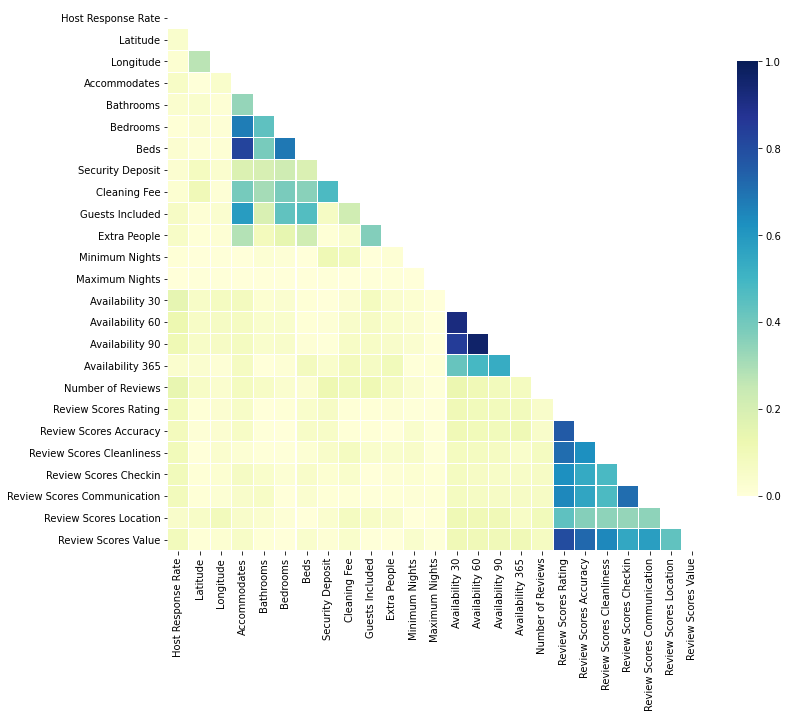

In [ ]:
# Para tener una visión más intuitiva es mejor dibujar la matriz de correlación
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr()) # Eliminamos el precio por ser la variable objetivo

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})


Las zonas azules en la gráfica es donde se muestra que hay correlación entre variables. Hay tres zonas diferenciadas:

- Correlación clara entre beds y accommodates (0.8253). Es una relación lógica porque es el número de personas que pueden entrar a la vivienda y el número de camas disponibles. Eliminaremos accommodates (en módulos anteriores se vio la misma relación).
- Tenemos también correlación entre las variables Availability. Nos quedaremos con Availability 365.
- Asimismo hay correlación entre las variables Review, lo cual también tiene su lógica ya que son características evaluadas de la vivienda y muchas veces están relaciondas, ya que las evalúa la misma persona. En pro de reducir la dimensionalidad, lo ideal es eliminarlas. Lo normal en estos casos sería hacer una media entre estas características, pero hay una variable, Review Score Value, que parece ser una valoración general (media) que realiza el inquilino acerca de la vivienda. Por tanto, consideraremos esta variable de mayor fiabilidad que un cálculo medio obtenido matemáticamente.

En definitiva, debemos eliminar las siguientes columnas por estar correlacionadas:

'Accommodates', 'Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication' y 'Review Scores Location'

In [ ]:
df.drop(get_correlated_columns(), axis=1, inplace=True)
df.shape

(8525, 27)

Para terminar este epígrafe, podemos hacer una representación (scatter_plot) de todas las variables frente al resto, para tener una idea de cómo se relacionan las variables del problema.

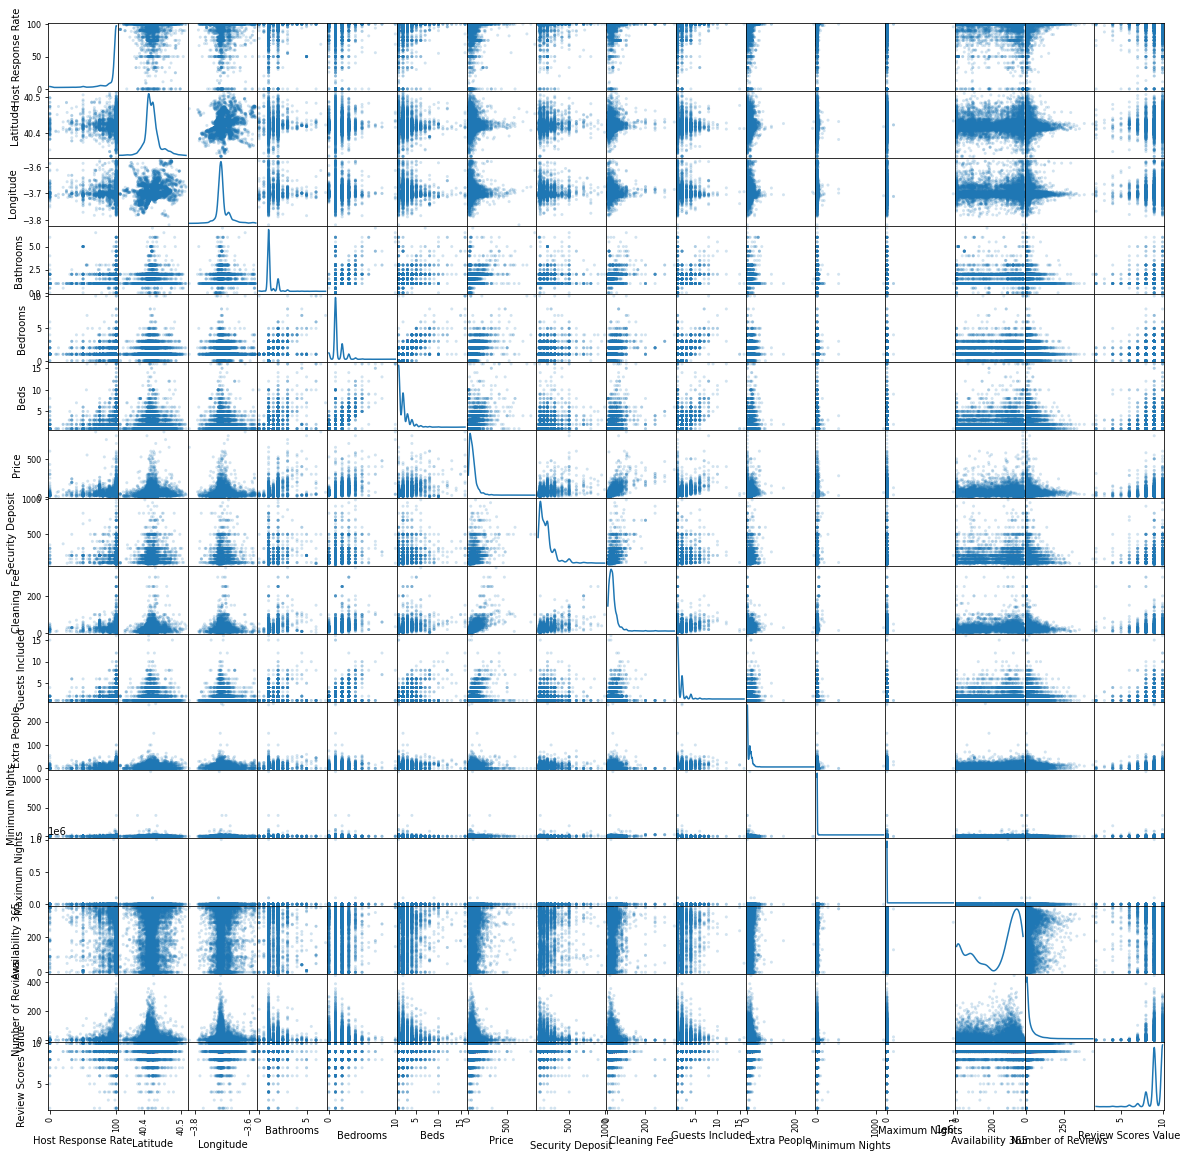

In [ ]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

## 3.5 Análisis de outliers, valores 0 y valores nulos
En este epígrafe comprobaremos si hay algún outlier, principalmente, en la variable objetivo. También controlaremos los valores nulos, y 0 en las columnas numéricas.

In [ ]:
# Para facilitar el análisis, es conveniente que la variable objetivo sea la primera o la última columna de nuestro dataset. 
# En nuestro caso, vamos a situarla en la primera columna.
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df = df[cols]

In [ ]:
# Hacemos un describe del dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,8525.0,65.529267,55.901326,9.000000,30.000000,51.000000,80.000000,850.000000
Host Response Rate,7473.0,94.876489,15.184928,0.000000,100.000000,100.000000,100.000000,100.000000
Latitude,8525.0,40.420615,0.020255,40.331888,40.410013,40.418630,40.428122,40.514247
Longitude,8525.0,-3.696939,0.023769,-3.819501,-3.707905,-3.701548,-3.693607,-3.573613
Bathrooms,8497.0,1.250324,0.592499,0.000000,1.000000,1.000000,1.000000,7.000000
Bedrooms,8514.0,1.295866,0.840345,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,8498.0,1.985761,1.531178,1.000000,1.000000,2.000000,2.000000,16.000000
Security Deposit,3630.0,183.300826,110.008281,70.000000,100.000000,150.000000,200.000000,990.000000
Cleaning Fee,5036.0,29.261914,24.847505,4.000000,15.000000,25.000000,35.000000,350.000000
Guests Included,8525.0,1.583343,1.105213,1.000000,1.000000,1.000000,2.000000,16.000000


### 3.5.1 Outliers

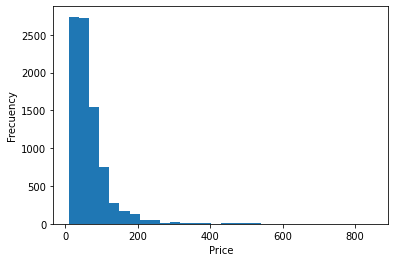

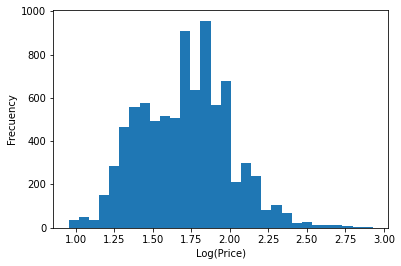

In [ ]:
# Llama la atención en Price que siendo la media 65.395 haya un máximo de 850. Vamos a reliazar un histograma. 
plt.hist(df['Price'], bins=30)
plt.xlabel('Price')
plt.ylabel('Frecuency')
plt.show()

plt.hist(np.log10(df['Price']), bins=30)
plt.xlabel('Log(Price)')
plt.ylabel('Frecuency')
plt.show()


In [ ]:
# Por las gráficas, vemos que los valores outlier se presentan por encima de 200. Estos valores pueden corresponder a
# viviendas similares a hoteles o viviendas de lujo. Vamos a poner el filtro en 300.
# Nuestro modelo no podrá predecir el pecio para viviendas caras y/o de lujo
len(df[df['Price'] > 300])

63

In [ ]:
# La variable Price es nuestro objetivo. Debemos tener en cuenta sus valores nulo.
# En principio, no debería haber ningún valor nulo porque los hemos eliminado al
# principio
len(df[df['Price'].isnull()])

0

In [ ]:
# Normalmente, los valores nulo numéricos se suelen rellenan con el valor medio. En el caso de 
# de la variable objetivo, dado que tenemos pocas filas con nulo, vamos a borrarlas para no influir en los cálculos
# de predicción y/o clasificación.
# Finalmente, en el caso de la variable Price borraremos todas las filas con nulos y con un valor superior a 300.
df = df[(df['Price'] <= 300)]

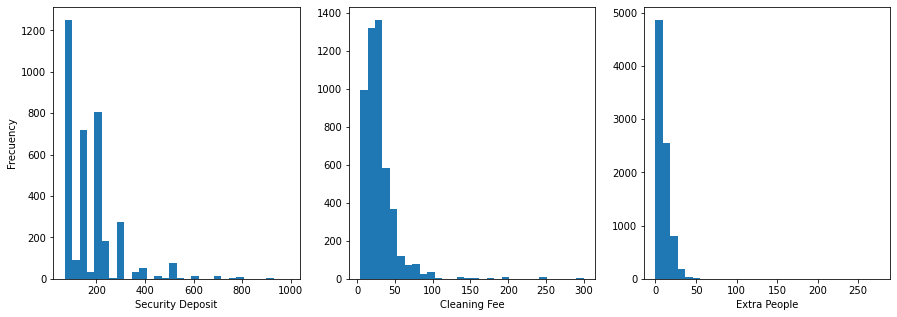

In [ ]:
plt.figure(figsize=(15, 5))
# Revisamos los datos de security deposit y cleaning fee

plt.subplot(1,3,1)
plt.hist(df['Security Deposit'], bins=30)
plt.xlabel('Security Deposit')
plt.ylabel('Frecuency')

plt.subplot(1,3,2)
plt.hist(df['Cleaning Fee'], bins=30)
plt.xlabel('Cleaning Fee')

plt.subplot(1,3,3)
plt.hist(df['Extra People'], bins=30)
plt.xlabel('Extra People')

plt.show()


<div class = "alert alert-success">
En entregas de otros módulos del Bootcamp se han analizado relaciones entre security deposit, cleaning fee y price, creando, por ejemplo, una nueva caracterítisca sumando los tres valores, lo cual, aunque en sí mismo no tiene sentido porque el precio es un valor diario, el depósito es una único que al final se devuelve y la tasa de limpieza no queda claro cuál es su frecuencia, puede servir de referencia. La tasa de limpieza influye en la predicción del precio. El depósito en teoría debería influir menos porque es un pago inicial que al final del alquiler se devuelve. Únicamente influirá si es muy alto.
    
TODO: realizar un estudio más exhaustivo de cleaning fee
    
</div>


In [ ]:
print(f"Filas con más de 650 en Security Deposit {len(df[df['Security Deposit'] > 650])}")
print(f"Filas con más de 150 en Cleaning Fee {len(df[df['Cleaning Fee'] > 150])}")
print(f"Filas con más de 50 en Extra People {len(df[df['Extra People'] > 50])}")

Filas con más de 650 en Security Deposit 33
Filas con más de 150 en Cleaning Fee 25
Filas con más de 50 en Extra People 15


In [ ]:
# Como son relativamente pocos registros, procedemos a borrarlos. Aunque un depósito de 650 y más de 50 personas extras 
# sigue siendo umbrales altos, dejamos estos valores como filtros. Un depósito mayor de 650 puede ser correcto, aunque es un
# tipo de vivienda que no se corresponde con lo que es usual en AirBnB. Lo mismo podemos decir de Cleaning Fee. Más de 50 
# personas extra no tiene sentido, y debe ser algún error.
df = df[(df['Security Deposit'] <= 650) | (df['Security Deposit'].isnull())]
df = df[(df['Cleaning Fee'] <= 150) | (df['Cleaning Fee'].isnull())]
df = df[(df['Extra People'] <= 50) | (df['Extra People'].isnull())]

In [ ]:
# Volvemos a realizar un describe del dataset para comprobar si se siguen manteniendo valores outlier
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,8396.0,61.940686,42.470106,9.000000,30.000000,50.000000,80.000000,300.000000
Host Response Rate,7361.0,94.871077,15.141868,0.000000,100.000000,100.000000,100.000000,100.000000
Latitude,8396.0,40.420548,0.020313,40.331888,40.409949,40.418488,40.428063,40.514247
Longitude,8396.0,-3.696954,0.023795,-3.789276,-3.707926,-3.701614,-3.693807,-3.573613
Bathrooms,8368.0,1.235241,0.564177,0.000000,1.000000,1.000000,1.000000,7.000000
Bedrooms,8385.0,1.274419,0.794450,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,8369.0,1.949337,1.449291,1.000000,1.000000,1.000000,2.000000,16.000000
Security Deposit,3554.0,175.699775,91.405996,70.000000,100.000000,150.000000,200.000000,650.000000
Cleaning Fee,4936.0,27.421596,17.824005,4.000000,15.000000,25.000000,35.000000,150.000000
Guests Included,8396.0,1.573726,1.074883,1.000000,1.000000,1.000000,2.000000,16.000000


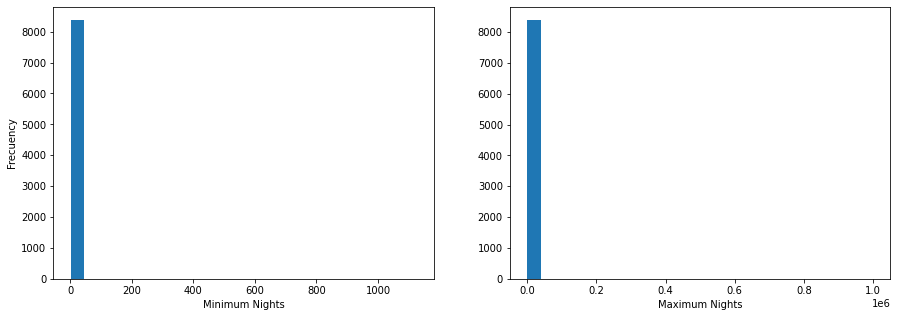

In [ ]:
# Resulta llamativo el valor máximo y mínimo Nights 
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df['Minimum Nights'], bins=25)
plt.xlabel('Minimum Nights')
plt.ylabel('Frecuency')

plt.subplot(1,2,2)
plt.hist(df['Maximum Nights'], bins=25)
plt.xlabel('Maximum Nights')

plt.show()


In [ ]:
print(f"Filas con más de 365 en Minimum Nights {len(df[df['Minimum Nights'] > 365])}")
print(f"Filas con más de 1125 en Maximum Nights {len(df[df['Maximum Nights'] > 1125])}")

Filas con más de 365 en Minimum Nights 1
Filas con más de 1125 en Maximum Nights 41


In [ ]:
# Son relativamente pocos registros y como no desvirtúan el dataset, procedemos a borrarlos.
df = df[(df['Minimum Nights'] <= 365) | (df['Minimum Nights'].isnull())]
df = df[(df['Maximum Nights'] <= 1125) | (df['Maximum Nights'].isnull())]

### 3.5.2 Valores cero

Revisando la tabla obtenida tras ejecutar un describe, vemos que hay columnas con una valor mínimo 0. Las más llamativas son Bathrooms y Bedrooms

In [ ]:
print(f"Filas sin ningún baño {len(df[df['Bathrooms'] == 0])}")
print(f"Filas sin ninguna habitación {len(df[df['Bedrooms'] == 0])}")


Filas sin ningún baño 39
Filas sin ninguna habitación 586


Vemos que hay 586 viviendas sin habitaciones. Son muchas y no parece un error. Consideramos que son viviendas de tipo estudio. 

Asimismo vemos que hay 39 viviendas sin baño. Puede considerarse que es un error, o puede considerarse que son viviendas de tipo pensión o similar que tienen baño compartido. Se puede considerar correcto tanto eliminar las filas con baños cero, como no eliminarlas (esta es la conclusión a la que se llegó en anteriores módulos). En este caso vamos a decidir no borrar las filas. En posteriores estudios se podrían borrar.

### 3.5.3 Valores nulos

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,8354.0,61.931171,42.514120,9.000000,30.000000,50.000000,80.000000,300.000000
Host Response Rate,7321.0,94.851933,15.177994,0.000000,100.000000,100.000000,100.000000,100.000000
Latitude,8354.0,40.420559,0.020349,40.331888,40.409938,40.418496,40.428074,40.514247
Longitude,8354.0,-3.696941,0.023838,-3.789276,-3.707920,-3.701613,-3.693790,-3.573613
Bathrooms,8326.0,1.235407,0.564687,0.000000,1.000000,1.000000,1.000000,7.000000
Bedrooms,8343.0,1.272684,0.790637,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,8327.0,1.943917,1.440834,1.000000,1.000000,1.000000,2.000000,16.000000
Security Deposit,3531.0,175.715944,91.436193,70.000000,100.000000,150.000000,200.000000,650.000000
Cleaning Fee,4903.0,27.428921,17.859834,4.000000,15.000000,25.000000,35.000000,150.000000
Guests Included,8354.0,1.572660,1.074970,1.000000,1.000000,1.000000,2.000000,16.000000


En tabla anterior vemos que hay algunas columnas que tienen menos valores en la columna *count* que en número de filas que tiene el dataframe. Esto se debe a que hay valores nulos que deben ser cumplimentados. Normalmente, los valores nulos numéricos se rellenan con la media y los nulos categóricos con la moda.

En nuestro caso, vemos que hay tres columnas que si tienen valor nulo, lo correcto es rellenarlos con 0. Si no se ha indicado nada en 'Security Deposit', 'Cleaning Fee' o en 'Host Response Rate', lo lógico es pensar que no se cobra nada por el depósito de seguridad y la tasa de limpieza o que el dueño no ha realizado ninguna respuesta.

In [ ]:
fillna_with_zero(df)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,8354.0,61.931171,42.514120,9.000000,30.000000,50.000000,80.000000,300.000000
Host Response Rate,8354.0,83.123175,34.306417,0.000000,90.000000,100.000000,100.000000,100.000000
Latitude,8354.0,40.420559,0.020349,40.331888,40.409938,40.418496,40.428074,40.514247
Longitude,8354.0,-3.696941,0.023838,-3.789276,-3.707920,-3.701613,-3.693790,-3.573613
Bathrooms,8326.0,1.235407,0.564687,0.000000,1.000000,1.000000,1.000000,7.000000
Bedrooms,8343.0,1.272684,0.790637,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,8327.0,1.943917,1.440834,1.000000,1.000000,1.000000,2.000000,16.000000
Security Deposit,8354.0,74.270170,105.206935,0.000000,0.000000,0.000000,150.000000,650.000000
Cleaning Fee,8354.0,16.098157,19.225441,0.000000,0.000000,10.000000,30.000000,150.000000
Guests Included,8354.0,1.572660,1.074970,1.000000,1.000000,1.000000,2.000000,16.000000


In [ ]:
# El resto de columnas las rellenamos con la media. En teoría, deberíamos rendondear las medias obtenidas porque
# las variables siguientes solo admiten números enteros (hay una o dos camas, pero no cama y media);
# decidimos dejar los valores con decimales, porque favoceren las predicción del precio y, en caso de necesidad,
# es más fácil localizar las filas en las que estos datos se han rellenado automáticamente.

# Guardamos los valores medios en variables para poder luegar asignar estos valores al dataset de test.

mean_Bathrooms = df['Bathrooms'].mean()
mean_Bedrooms = df['Bedrooms'].mean()
mean_Beds = df['Beds'].mean()
mean_Review_Scores_Value = df['Review Scores Value'].mean()
print (f'Media de baños {mean_Bathrooms}')
print (f'Media de habitaciones {mean_Bedrooms}')
print (f'Media de camas {mean_Beds}')
print (f'Media de puntaciones {mean_Review_Scores_Value}')

df = fillna_with_means(df, mean_Bathrooms, mean_Bedrooms, mean_Beds
    , mean_Review_Scores_Value)
df.describe().T

Media de baños 1.2354071582993034
Media de habitaciones 1.272683686923169
Media de camas 1.9439173772066771
Media de puntaciones 9.216851038036067


,count,mean,std,min,25%,50%,75%,max
Price,8354.0,61.931171,42.514120,9.000000,30.000000,50.000000,80.000000,300.000000
Host Response Rate,8354.0,83.123175,34.306417,0.000000,90.000000,100.000000,100.000000,100.000000
Latitude,8354.0,40.420559,0.020349,40.331888,40.409938,40.418496,40.428074,40.514247
Longitude,8354.0,-3.696941,0.023838,-3.789276,-3.707920,-3.701613,-3.693790,-3.573613
Bathrooms,8354.0,1.235407,0.563739,0.000000,1.000000,1.000000,1.000000,7.000000
Bedrooms,8354.0,1.272684,0.790116,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,8354.0,1.943917,1.438504,1.000000,1.000000,1.000000,2.000000,16.000000
Security Deposit,8354.0,74.270170,105.206935,0.000000,0.000000,0.000000,150.000000,650.000000
Cleaning Fee,8354.0,16.098157,19.225441,0.000000,0.000000,10.000000,30.000000,150.000000
Guests Included,8354.0,1.572660,1.074970,1.000000,1.000000,1.000000,2.000000,16.000000


## 3.6 Variables categóricas

En este apartado vamos a analizar las variables no numéricas

In [ ]:
list(df.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Host Since',
 'Host Response Time',
 'Host Verifications',
 'Neighbourhood Cleansed',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Amenities',
 'Cancellation Policy',
 'Features']

In [ ]:
df_objects = df[list(df.select_dtypes(include=['object']).columns)]
df_objects.head(10)

,Experiences Offered,Host Since,Host Response Time,Host Verifications,Neighbourhood Cleansed,Property Type,Room Type,Bed Type,Amenities,Cancellation Policy,Features
0,none,2017-03-09,within an hour,"email,reviews",Universidad,Apartment,Entire home/apt,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",flexible,"Host Has Profile Pic,Is Location Exact,Require..."
1,none,2016-10-17,within a day,"email,phone,work_email",Universidad,Apartment,Private room,Real Bed,"Internet,Wireless Internet,Kitchen,Elevator in...",flexible,"Host Has Profile Pic,Requires License"
2,none,2016-03-30,a few days or more,"email,phone",Palos de Moguer,Apartment,Private room,Real Bed,"Wireless Internet,Kitchen,Family/kid friendly,...",flexible,"Host Has Profile Pic,Requires License"
3,none,2017-04-05,NaN,"email,phone",Palacio,Loft,Entire home/apt,Real Bed,"Wireless Internet,Air conditioning,Kitchen,Smo...",flexible,"Host Has Profile Pic,Requires License,Instant ..."
5,none,2016-10-21,within a few hours,"email,phone,reviews",Cortes,Bed & Breakfast,Private room,Real Bed,"Wireless Internet,Kitchen,Elevator in building...",moderate,"Host Has Profile Pic,Requires License"
6,none,2012-06-01,within a day,"email,phone,facebook,reviews,jumio",Almenara,Apartment,Entire home/apt,Real Bed,"TV,Wireless Internet,Air conditioning,Wheelcha...",moderate,"Host Has Profile Pic,Host Identity Verified,Is..."
7,none,2012-10-22,within an hour,"email,phone,reviews",Universidad,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",moderate,"Host Is Superhost,Host Has Profile Pic,Is Loca..."
8,none,2010-01-31,within a few hours,"email,phone,facebook,reviews",Castellana,Apartment,Entire home/apt,Real Bed,"TV,Cable TV,Wireless Internet,Air conditioning...",flexible,"Host Has Profile Pic,Is Location Exact,Require..."
9,none,2015-05-30,within a day,"email,phone,reviews,jumio",Embajadores,Apartment,Entire home/apt,Real Bed,"Wireless Internet,Kitchen,Family/kid friendly,...",flexible,"Host Has Profile Pic,Host Identity Verified,Is..."
11,none,2012-02-22,NaN,"email,phone,facebook,reviews,jumio,work_email",Justicia,Apartment,Entire home/apt,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Air con...",moderate,"Host Has Profile Pic,Host Identity Verified,Re..."


Vamos a realizar una serie de comprobaciones similares a las realizadas con las variables numéricas

### 3.6.1 Valores nulo

Igual que antes, comprobaremos los valores nulos de cada variable de tipo object

In [ ]:
len(df_objects) - df_objects.count()

Experiences Offered          0
Host Since                   2
Host Response Time        1033
Host Verifications           4
Neighbourhood Cleansed       0
Property Type                0
Room Type                    0
Bed Type                     0
Amenities                   71
Cancellation Policy          0
Features                     0
dtype: int64

In [ ]:
# Observamos que 'Host Since' tiene solo dos fila nulas, por lo que procedemos a borrarlas
df = dropna_in_host_since(df)

In [ ]:
# Host Verifications y Amenities son columnas que tienen listas de valores separadas por comas. Lo lógico es pensar que 
# si un valor es nulo, lo equivalente es poner cadena vacía, es decir, lista vacía de valores. También trataremos estas
# columnas más adelante en la sección de Ponderación.
df = fillna_with_empty_string(df)

In [ ]:
# Por último, vemos que Host Reponse Time tiene bastantes nulos. En este caso, lo correcto es rellenar con la moda.
# Guardamos el cálculo de la moda para luego asignarlo al dataset de test
mode_Host_Response_Time = df["Host Response Time"].mode()[0]
df = fillna_Host_Response_Time_with_its_mode(df, mode_Host_Response_Time)

In [ ]:
# Comprobamos de nuevo si hay nulos
df_objects = df[list(df.select_dtypes(include=['object']).columns)]
len(df_objects) - df_objects.count()

Experiences Offered       0
Host Since                0
Host Response Time        0
Host Verifications        0
Neighbourhood Cleansed    0
Property Type             0
Room Type                 0
Bed Type                  0
Amenities                 0
Cancellation Policy       0
Features                  0
dtype: int64

### 3.6.2 Valores vacíos

En este apartado se tratarán valores de cadena que se consideren valor vacíos equivalentes a nulo. En este sentido, la columna que presenta un valor de este estilo es *Experiences Offered*: none

In [ ]:
df["Experiences Offered"].value_counts()

none    8352
Name: Experiences Offered, dtype: int64

In [ ]:
# Vemos que todos sus valores son none, por tanto, procedemos a borrar esta columna
df = df.drop(get_empty_columns(), axis=1)
df.shape

(8352, 26)

### 3.6.3 Conversión de variables de tipo cadena a tipo numérico

#### 3.6.3.1 Encoding
En este apartado vamos a estudiar si es posible y tiene sentido sustituir literales/categorías por números, esto es, realizar operaciones de codificación (encoding) de variables cuyos valores son listas acotadas en forma texto.

Las columnas sobre las que vamos a relizar el estudio son:

'Host Response Time', 'Neighbourhood Cleansed', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy'

Podemos hacer un preanálisis de cómo estas variables están relacionadas con el precio mediante gráficos boxplot
 

**host respose time vs price**

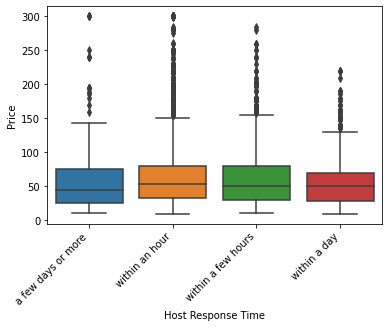

In [ ]:
sort_price = df.groupby('Host Response Time')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Host Response Time', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Vemos que la media del precio según el tiempo de respuesta del dueños es muy similar en todos los casos. No parece que influya.

**'Neighbourhood Cleansed vs price**

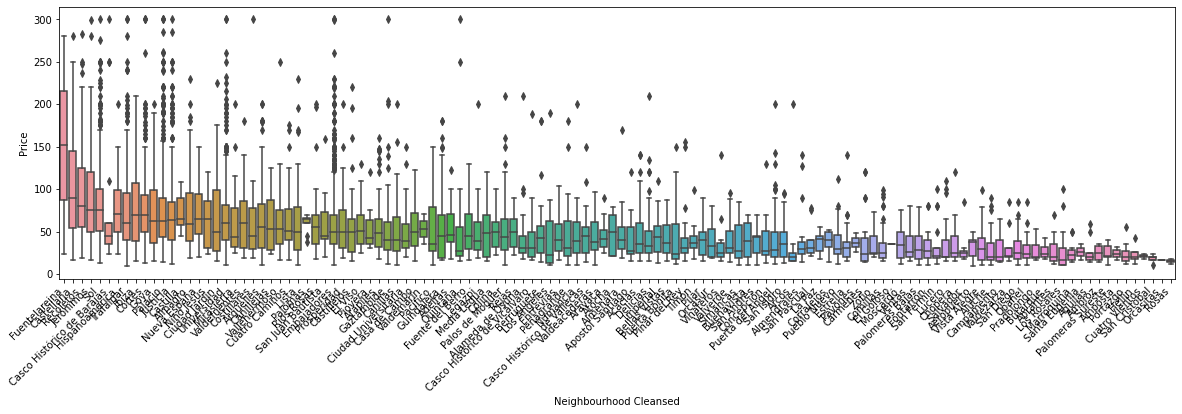

In [ ]:
plt.figure(figsize=(20, 5))
sort_price = df.groupby('Neighbourhood Cleansed')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Neighbourhood Cleansed', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Vemos que hay barrios cuya media de precio es claramente superior al resto. El barrio influye en el precio.

**property type**

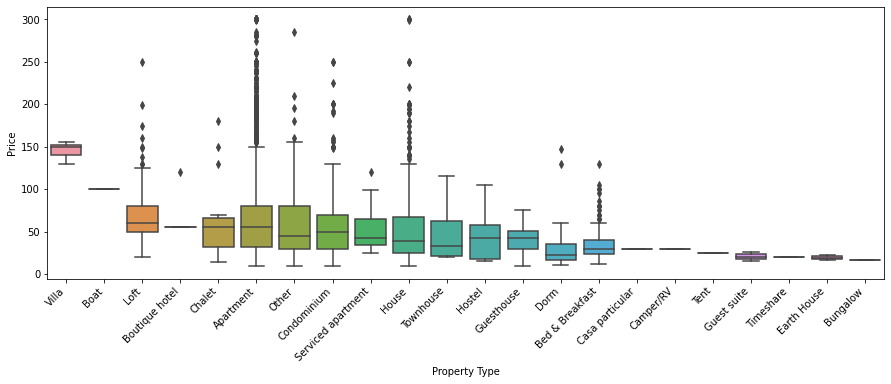

In [ ]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Property Type')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Property Type', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

El tipo de propiedad tiene influencia en el precio, ya que hay variación en la medias de los precios en algún tipo de propiedad (Villa)

**room type**

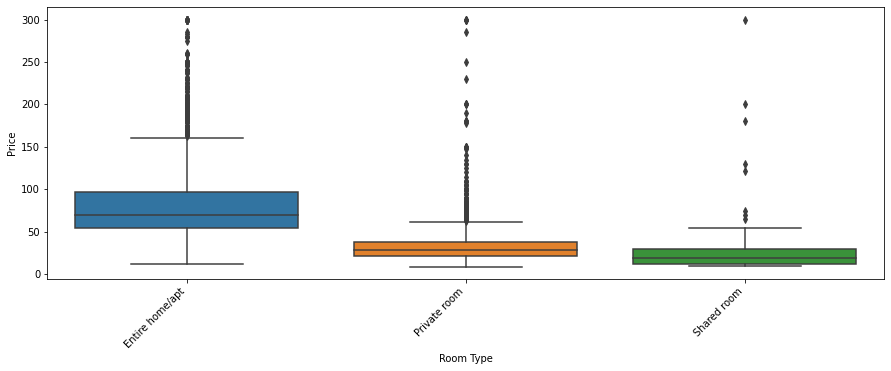

In [ ]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Room Type')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Room Type', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Las viviendas/apartamentos completos, sin el dueño en casa, son los de mayor precio. Podemos analizar también la cantidad de viviendas que se ofrecen de cada tipo, mediante un histograma de barras en pila (stacked)


Text(0.5, 0, 'Price')

<Figure size 1080x360 with 0 Axes>

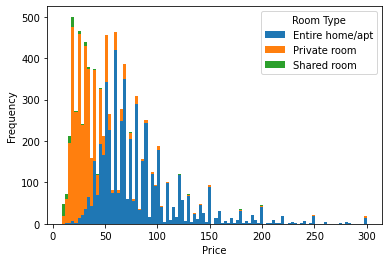

In [ ]:
plt.figure(figsize=(15, 5))
df.pivot(columns = 'Room Type', values = 'Price').plot.hist(stacked = True, bins=100)
plt.xlabel('Price')

Se observa que lo que más se ofrece son habitaciones privadas en la parte de precios menores, pero lo que más abarca, e incluso empezando en precios relativamente baratos, son las viviendas/apartamentos completos sin dueño.

**Bed type**

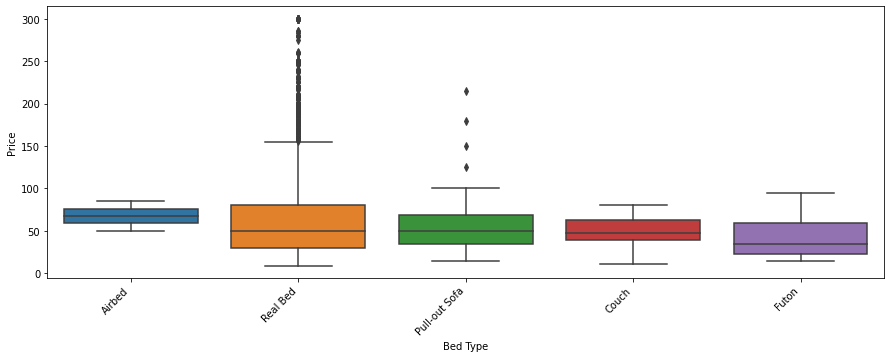

In [ ]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Bed Type')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Bed Type', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

El precio medio de la cama es más o menos el mismo para todos los tipos, aunque hay más variedad de precios en "Real Bed"

**Cancellation Policy**

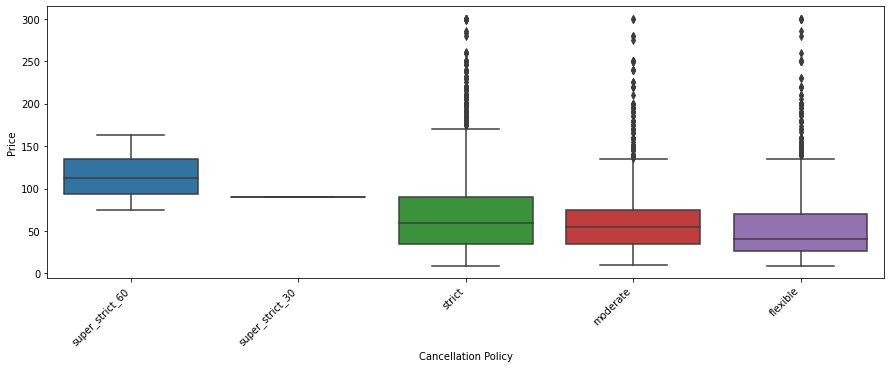

In [ ]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Cancellation Policy')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Cancellation Policy', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Los precios son diferentes en las distintas políticas de cancelación.

Realizado este preanálisis de estas variables con los precios medios, se decide sustutir cada valor (categoría) por la media del precio de dicho valor en cada columna analizada. Se va a utilizar la técnica de Mean Encoding explicada [aquí](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02).

Otra opción hubiera sido hacer el encoding, por ejemplo, de tipo OneHot, pero esta solución tiene dos problemas principales:

- Aumenta la dimensionalidad del dataset. El número de columnas del dataset se ve incrementado considerablemente ya que por cada valor de cada una de las características antes mencionadas se crea una columna. Por ejemplo, *Property Type* y *NeighbourhoodCleansed* tienen muchos valores diferentes.
- Existe el riesgo que un dataset de test tenga valores que no existan en el dataset de train. Se debe decidir qué hacer en estos casos. Lo normal, como los nuevos valores suelen tener pocas filas, es directamente, borrar dichas filas. No obstante, en determinados casos esta solución no suele ser correcta.

Por esta razón, se va a optar, como se ha indicado, por la solución del Mean Encoding, que sustituye cada valor por su media respecto a la variable objetivo. Por ejemplo, en el caso de los barrios sustituiremos el nombre del barrio por el precio medio de la vivienda en ese barrio. Con esta técnica conseguimos dos ventajas respecto a OneHot:
- No aumentamos la dimensionalidad
- Automáticamente damos más valor o clasificamos a los barrios más caros sobre los más baratos. El valor medio del precio del barrio es un dato con significado cuantitativo que permite comparaciones directas.

Por otro, en el caso de que en test aparezca un valor no procesado en train, lo que haremos es sustuirlo por el precio medio global. Otra opción hubiera sido hacer media de medias, esto es, por ejemplo, en el caso de los barrios, hacer la media de los precios de todos los barrios. No se opta por esta solución porque el valor obtenido se presume muy parecido al valor general. No obstante, se podría realizar un estudio posterior con las medias de medias.


In [ ]:
# Calculamos precios medios por cada categoría dentro de cada variable categórica
# Almacenamos los precios medios para su uso posterior
for var in get_categorical_variables():
    mean_price_map[var] = df.groupby(var)['Price'].mean()

# Guardamos el precio medio general por si en test hay variables categóricas que no están en train
# En este tipo de casos es bastante común hacer medias de medias, pero en el nuestro, hemos preferido utilizar el precio medio
# general, porque no hay mucha diferencia.
overall_mean_price = df['Price'].mean()    

# Asignamos    
df = mean_encoding_to_categorical_variables(df, mean_price_map, overall_mean_price)


#### 3.6.3.2 Ponderaciones

En este apartado vamos fijarmos en las columnas de tipos Object (string) que tienen internamente listas de valores separados por comas.

Las columnas que vamos a examinar son

'Amenities', 'Features' y 'Host Verifications'

In [ ]:
df.Amenities[:5].values

array(['TV,Wireless Internet,Air conditioning,Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Smoke detector,Safety card,Essentials,Hangers,Hair dryer,Iron,Laptop friendly workspace',
       'Internet,Wireless Internet,Kitchen,Elevator in building,Heating,Washer,Essentials,Shampoo,Hangers,Hair dryer,Iron,Laptop friendly workspace,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50',
       'Wireless Internet,Kitchen,Family/kid friendly,Washer,Smoke detector,Carbon monoxide detector,Fire extinguisher,translation missing: en.hosting_amenity_50',
       'Wireless Internet,Air conditioning,Kitchen,Smoking allowed,Pets allowed,Elevator in building,Heating,Family/kid friendly,Washer,Lock on bedroom door,Hangers,Laptop friendly workspace',
       'Wireless Internet,Kitchen,Elevator in building,Buzzer/wireless intercom,Heating,Essentials,Shampoo,24-hour check-in,Hangers,Hair dryer,translation missing: en.hosting_amenity_49,translation missing: 

In [ ]:
df.Features[:5].values

array(['Host Has Profile Pic,Is Location Exact,Requires License,Instant Bookable',
       'Host Has Profile Pic,Requires License',
       'Host Has Profile Pic,Requires License',
       'Host Has Profile Pic,Requires License,Instant Bookable',
       'Host Has Profile Pic,Requires License'], dtype=object)

In [ ]:
df['Host Verifications'][:5].values

array(['email,reviews', 'email,phone,work_email', 'email,phone',
       'email,phone', 'email,phone,reviews'], dtype=object)

En esta práctica se decide realizar la conversión más usual y simple cuando el contenido son listas: sustituir el contenido por el número de elementos que tiene la lista. Con esta conversión estamos indicando,a priori, que las viviendas que tienen más amenities, características o que el dueño tiene más medios de verificación tienen más influencia sobre el precio, lo cual, aunque parece una deducción lógica, no tiene por qué ser cierta.

<div class = "alert alert-success">
TODO: La solución adaptada es la más sencilla y directa, pero habría sido mejor realizar un estudio de, por ejemplo, Amenities, qué elementos son los que más influyen en el precio y asignarles un valor ponderado. Por ejemplo, una vivienda sin aire acondicionado, podría ser más barata, pero más difícil de alquilar. Parte del código que deberíamos desarrollar lo podemos encontrar en 
    <a href="https://github.com/peternmai/Airbnb_Price_Prediction/blob/master/AirBnB%20Price%20Prediction.ipynb" target="_blank">aquí</a>, en la función getAmenityList
</div>

In [ ]:
df=count_elements_in_list(df)

# 4 Generación de características

En esta sección añadiremos nuevas columnas/características a partir de las ya existentes para facilitar la predicción del precio.

Comprobamos si tenemos algún valor nulo en el dataframe (esta vez la comprobación la hacemos de manera distinta a como lo hemos hecho en otras ocasiones anteriormente)

In [ ]:
df.isna().sum()

Price                     0
Host Since                0
Host Response Time        0
Host Response Rate        0
Host Verifications        0
Neighbourhood Cleansed    0
Latitude                  0
Longitude                 0
Property Type             0
Room Type                 0
Bathrooms                 0
Bedrooms                  0
Beds                      0
Bed Type                  0
Amenities                 0
Security Deposit          0
Cleaning Fee              0
Guests Included           0
Extra People              0
Minimum Nights            0
Maximum Nights            0
Availability 365          0
Number of Reviews         0
Review Scores Value       0
Cancellation Policy       0
Features                  0
dtype: int64

Como era de esperar, ya no tenemos valores nulos

Ahora comprobaremos, los tipos de cada columna

In [ ]:
df.dtypes

Price                     float64
Host Since                 object
Host Response Time        float64
Host Response Rate        float64
Host Verifications          int64
Neighbourhood Cleansed    float64
Latitude                  float64
Longitude                 float64
Property Type             float64
Room Type                 float64
Bathrooms                 float64
Bedrooms                  float64
Beds                      float64
Bed Type                  float64
Amenities                   int64
Security Deposit          float64
Cleaning Fee              float64
Guests Included             int64
Extra People                int64
Minimum Nights              int64
Maximum Nights              int64
Availability 365            int64
Number of Reviews           int64
Review Scores Value       float64
Cancellation Policy       float64
Features                    int64
dtype: object

Nos queda una columna que todavía no es numérica: Host Since

## 4.1 Conversión de características

Comprobamos que sólo hay una variable, Host Since, de tipo Object. De esta columna solo nos interesa saber cuántos años tiene de antigüedad la vivienda en Airbnb a día de hoy (año 2020). 

In [ ]:
df = calculate_years(df)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,8352.0,61.929239,42.516493,9.000000,30.000000,50.000000,80.000000,300.000000
Host Response Time,8352.0,61.929239,2.416858,55.453416,61.670710,63.049722,63.049722,64.578313
Host Response Rate,8352.0,83.143080,34.286396,0.000000,90.000000,100.000000,100.000000,100.000000
Host Verifications,8352.0,4.112428,1.288260,1.000000,3.000000,4.000000,5.000000,10.000000
Neighbourhood Cleansed,8352.0,61.929239,15.832620,15.000000,52.658915,63.596591,74.082111,151.500000
Latitude,8352.0,40.420557,0.020344,40.331888,40.409939,40.418496,40.428070,40.514247
Longitude,8352.0,-3.696945,0.023839,-3.789276,-3.707926,-3.701614,-3.693801,-3.573613
Property Type,8352.0,61.929239,6.079391,17.000000,63.778053,63.778053,63.778053,145.000000
Room Type,8352.0,61.929239,24.345941,27.968254,33.078012,82.325724,82.325724,82.325724
Bathrooms,8352.0,1.235464,0.563795,0.000000,1.000000,1.000000,1.000000,7.000000


## 4.2 Creación de nuevas características utilizando datos externos

Para enriquecer más el dataset se podrían añadir nuevas características, como, por ejemplo, la distancia de cada vivienda a los puntos turísticos de Madrid. Esta operación se realizó en módulos anteriores y no se obtuvieron resultados significativamente diferentes a los obtenidos sin añadir esta nueva característica. Por esa razón, en esta práctica no se va a llevar a cabo.


## 4.3 Creación de etiquetas
Como se ha observado en la sección de EDA, los datos del precio están escorados hacia la izquierda, ya que hay muy pocas viviendas caras. 

Vamos a clasificar las viviendas en baratas (0), normales (1) y caras (2)


In [ ]:
y_train_class = create_labels(df)


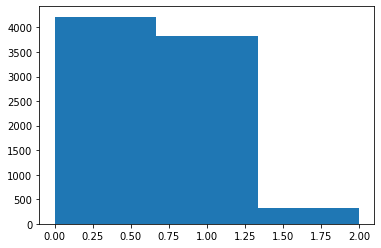

In [ ]:
# veamos cómo ha quedado la distribución al convertirla a 3 clases
plt.hist(y_train_class, bins=3)
plt.show()

# 5 Creación y validación de modelos
En este apartado vamos a crear y validar los siguientes tipo de modelos:
- Modelos solo con los datos numéricos y categóricos
  - Clasificación
  - Regresión
- Modelos solo con los datos de imágenes
  - Clasificación
  - Regresión
- Modelos datos numéricos, categóricos e imágenes
  - Clasificación
  - Regresión


En clase y en los slack se aconsejó realizar el estudio del siguiente modo:

- clasificacion con datos numéricos y categóricos (“bucketizando” la variable Price)
- clasificacion con imágenes
- clasificación con numéricos/categóricos + imágenes
- los mismos 3 de arriba pero regresión

En este notebook, sin embargo, se ha preferido seguir el primer índice porque facilita la creación y reutilización de los dataframe de train, validación y test.

## 5.1 Modelos solo con datos numéricos y categóricos

### 5.1.1 Clasificación



In [ ]:
# Por los procesos anteriores ya tenemos X_train y sus labels 
# Hay que tener en cuenta que en df realmente tenemos el dataframe de train.

data = df.values

X_train = data[:,1:]      # nos quedamos con todas las columnas menos el precio

df.max(axis=0)

Price                      300.000000
Host Response Time          64.578313
Host Response Rate         100.000000
Host Verifications          10.000000
Neighbourhood Cleansed     151.500000
Latitude                    40.514247
Longitude                   -3.573613
Property Type              145.000000
Room Type                   82.325724
Bathrooms                    7.000000
Bedrooms                    10.000000
Beds                        16.000000
Bed Type                    67.500000
Amenities                   31.000000
Security Deposit           650.000000
Cleaning Fee               150.000000
Guests Included             16.000000
Extra People                50.000000
Minimum Nights             365.000000
Maximum Nights            1125.000000
Availability 365           365.000000
Number of Reviews          446.000000
Review Scores Value         10.000000
Cancellation Policy        116.000000
Features                     8.000000
Years                       11.000000
dtype: float

In [ ]:
# Normalizamos los datos de train (valores entre 0 y 1). 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
XtrainScaled = min_max_scaler.fit_transform(X_train)

In [ ]:
XtrainScaled.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# Los datos de y_class no hace falta normalizarlos porque son clases
# Vamos a aplicarles OneHot, ya que sólo son tres clases y además no hay
# peligro que un dataset de test no tenga alguna de las clases, porque
# dichas clases, tal y como se ha visto en la función de creación de labels
# se realiza por separación de rangos
from keras.utils import to_categorical

y_training_class_onehot = to_categorical(y_train_class)


Using TensorFlow backend.


In [ ]:
# Para crear el modelo debemos dividir el dataset de train, en train y validation
# Como hemos podido observar en el gráfico, los precios no están correctamente
# distribuidos. Por esa razón, vamos a estratificar para que los dataset
# obtenidos para los modelos estén balanceados en la medida de lo posible
X_train, X_val, y_train, y_val = train_test_split(XtrainScaled, y_training_class_onehot
                  , test_size=0.1, random_state=0, stratify=y_training_class_onehot)

In [ ]:
# Creamos modelo de clasificación con tres capas densas
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Asignamos el valor 3, porque tenemos 3 clases

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)
#          batch_size=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 7516 samples, validate on 836 samples
Epoch 1/50
7516/7516 [==============================] - 1s 187us/step - loss: 0.5453 - accuracy: 0.7987 - val_loss: 0.4693 - val_accuracy: 0.8014
Epoch 2/50
7516/7516 [==============================] - 1s 141us/step - loss: 0.4634 - accuracy: 0.8125 - val_loss: 0.4436 - val_accuracy: 0.8050
Epoch 3/50
7516/7516 [==============================] - 1s 148us/step - loss: 0.4450 - accuracy: 0.8172 - val_loss: 0.4638 - val_accuracy: 0.7895
Epoch 4/50
7516/7516 [==============================] - 1s 149us/step - loss: 0.4351 - accuracy: 0.8224 - val_loss: 0.4239 - val_accuracy: 0.8254
Epoch 5/50
7516/7516 [==============================] - 1s 143us/step - loss: 0.4297 - accuracy: 0.8221 - val_loss: 0.4182 - val_accuracy: 0.8134
Epoch 6/50
7516/7516 [==============================] - 1s 147us/step - loss: 0.4277 - accuracy: 0.8237 - val_loss: 0.4213 - val_accuracy: 0.

In [ ]:
# Para calcular el accuracy y las pérdidas vamos a recuperar y tratar el dataset de test
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# Realizamos a test todas las transformaciones realizadas a train, con la medias y demás factores de train
df_test = drop_columns_and_filter_rows_in_test_set(df_test 
    , mean_Bathrooms, mean_Bedrooms, mean_Beds, mean_Review_Scores_Value
    , mode_Host_Response_Time, mean_price_map, overall_mean_price)

# Creamos la etiquetas de test
y_test_class = create_labels(df_test)

In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,2088.0,62.254310,43.335698,10.000000,30.000000,50.000000,80.000000,300.000000
Host Response Time,2088.0,61.988213,2.354381,55.453416,61.670710,63.049722,63.049722,64.578313
Host Response Rate,2088.0,82.114464,35.394198,0.000000,90.000000,100.000000,100.000000,100.000000
Host Verifications,2088.0,4.126437,1.328365,1.000000,3.000000,4.000000,5.000000,9.000000
Neighbourhood Cleansed,2088.0,62.132072,15.816829,18.000000,52.614955,63.596591,74.082111,105.372881
Latitude,2088.0,40.420349,0.019869,40.340953,40.409973,40.418727,40.427345,40.514125
Longitude,2088.0,-3.697174,0.023196,-3.795734,-3.707658,-3.701520,-3.693944,-3.576992
Property Type,2088.0,61.920904,5.770194,19.500000,63.778053,63.778053,63.778053,68.193370
Room Type,2088.0,61.861708,24.371506,27.968254,33.078012,82.325724,82.325724,82.325724
Bathrooms,2088.0,1.263227,0.639715,0.000000,1.000000,1.000000,1.000000,8.000000


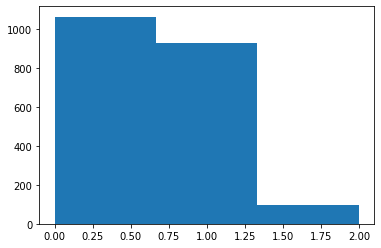

In [ ]:
plt.hist(y_test_class, bins=3)
plt.show()

In [ ]:
# A continuación debemos escalar test del mismo modo que train
data_test = df_test.values
X_test = data_test[:,1:]  # nos quedamos con todas las columnas menos el precio
# Escalamos test
XtestScaled = min_max_scaler.fit_transform(X_test)
# Transformamos a OnoHot la clase de test
y_test_class_onehot = to_categorical(y_test_class)


In [ ]:
loss, acc = model.evaluate(XtestScaled, y_test_class_onehot)
print(f'Loss={loss}, Acc={acc}')

2088/2088 [==============================] - 0s 22us/step
Loss=0.5637654445180491, Acc=0.7978927493095398


Obtenemos un accuracy de un 79.78%, lo cual es bastante sorprendente, teniendo en cuenta que no se ha aplicado ninguna forma de mejora, como regularizaciones, dropouts, etc. 

### 5.1.2 Regresión lineal

In [ ]:
# Repetimos algunas de las operaciones ya hechas en clasificación.
# Aunque el código repetimos código repecto a pasos anteriores, lo hacemos para 
# poder ejecutar estas sentencias de forma directa sin tener que ejecutar 
# primero las de clasificación
data = df.values

df.max(axis=0)


Price                      300.000000
Host Response Time          64.578313
Host Response Rate         100.000000
Host Verifications          10.000000
Neighbourhood Cleansed     151.500000
Latitude                    40.514247
Longitude                   -3.573613
Property Type              145.000000
Room Type                   82.325724
Bathrooms                    7.000000
Bedrooms                    10.000000
Beds                        16.000000
Bed Type                    67.500000
Amenities                   31.000000
Security Deposit           650.000000
Cleaning Fee               150.000000
Guests Included             16.000000
Extra People                50.000000
Minimum Nights             365.000000
Maximum Nights            1125.000000
Availability 365           365.000000
Number of Reviews          446.000000
Review Scores Value         10.000000
Cancellation Policy        116.000000
Features                     8.000000
Years                       11.000000
dtype: float

In [ ]:
# Normalizamos los datos de train (valores entre 0 y 1). 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(data)
y_scaled_train = data_scaled[:,0:1] # En la 1ª columna está Price, nuestra variable objetivo
X_scaled_train = data_scaled[:,1:] # Resto de columnas

In [ ]:
X_scaled_train.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

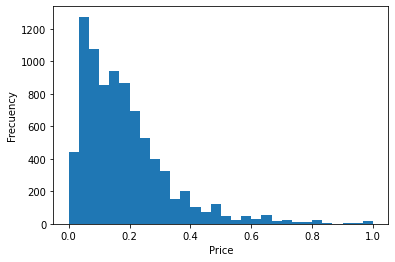

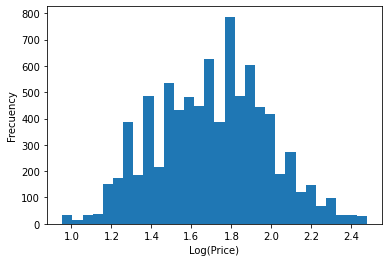

In [ ]:
plt.hist(y_scaled_train, bins=30)
plt.xlabel('Price')
plt.ylabel('Frecuency')
plt.show()

plt.hist(np.log10(df['Price']), bins=30)
plt.xlabel('Log(Price)')
plt.ylabel('Frecuency')
plt.show()

Se puede observar que la variable objetivo no está balanceada. Si hacemos una conversión logarítmica observamos que se aproxima a una distribución normal. Una posibilidad, por tanto, es convertir la variable objetivo a su versión logarítmica y utilizarla en la creación del modelo. Esta operación sería el equivalente, en cierto modo, a la estratificación realizada en la clasificación. Sin embargo, esta conversión la dejaremos para estudios posteriores. Queremos saber cuál es el resultado sin aplicar ninguna mejora en el procedimiento.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled_train, y_scaled_train
                  , test_size=0.1, random_state=0)

In [ ]:
# Repetimos las declaraciones, aunque ya están importadas en pasos anteriores
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # En este caso solo es una neurona porque solo tenemos una salida: directamente el precio

# Utilizamos funciones loss y optimizer acordes con la regresión lineal
# Aunque hay diferentes optimizer, elegimos RMSProp
model.compile(loss='mean_squared_error', optimizer='RMSProp')

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 7516 samples, validate on 836 samples
Epoch 1/50
7516/7516 [==============================] - 1s 162us/step - loss: 0.0119 - val_loss: 0.0112
Epoch 2/50
7516/7516 [==============================] - 1s 146us/step - loss: 0.0087 - val_loss: 0.0100
Epoch 3/50
7516/7516 [==============================] - 1s 136us/step - loss: 0.0081 - val_loss: 0.0087
Epoch 4/50
7516/7516 [==============================] - 1s 135us/step - loss: 0.0078 - val_loss: 0.0084
Epoch 5/50
7516/7516 [==============================] - 1s 142us/step - loss: 0.0076 - val_loss: 0.0085
Epoch 6/50
7516/7516 [==============================] - 1s 140us/step - loss: 0.0074 - val_loss: 0.0085
Epoch 7/50
7516/7516 [==============================] - 1s 145us/step - loss: 0.0073 - val_loss: 0.0084
Epoch 8/50
7516/7516 [==============================] - 1s 146us/step - loss: 0.0072 - val_loss: 0.0084
Epoch 9/50
7516/7516 [==============================] - 1s 137us/step - loss: 0.0071 - val_loss: 0.0100
Epoch 10/50
7516/

In [ ]:
# Para validar nuestro modelo recuperamos los datos de test
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# Realizamos a test todas las transformaciones realizadas a train, con la medias y demás factores de train
df_test = drop_columns_and_filter_rows_in_test_set(df_test 
    , mean_Bathrooms, mean_Bedrooms, mean_Beds, mean_Review_Scores_Value
    , mode_Host_Response_Time, mean_price_map, overall_mean_price)


In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,2088.0,62.254310,43.335698,10.000000,30.000000,50.000000,80.000000,300.000000
Host Response Time,2088.0,61.988213,2.354381,55.453416,61.670710,63.049722,63.049722,64.578313
Host Response Rate,2088.0,82.114464,35.394198,0.000000,90.000000,100.000000,100.000000,100.000000
Host Verifications,2088.0,4.126437,1.328365,1.000000,3.000000,4.000000,5.000000,9.000000
Neighbourhood Cleansed,2088.0,62.132072,15.816829,18.000000,52.614955,63.596591,74.082111,105.372881
Latitude,2088.0,40.420349,0.019869,40.340953,40.409973,40.418727,40.427345,40.514125
Longitude,2088.0,-3.697174,0.023196,-3.795734,-3.707658,-3.701520,-3.693944,-3.576992
Property Type,2088.0,61.920904,5.770194,19.500000,63.778053,63.778053,63.778053,68.193370
Room Type,2088.0,61.861708,24.371506,27.968254,33.078012,82.325724,82.325724,82.325724
Bathrooms,2088.0,1.263227,0.639715,0.000000,1.000000,1.000000,1.000000,8.000000


In [ ]:
# Normalizamos los datos de test (valores entre 0 y 1). 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_test = df_test.values
data_test_scaled = min_max_scaler.fit_transform(data_test)
y_scaled_test = data_test_scaled[:,0:1]  # En la 1ª columna está Price, nuestra variable objetivo
X_scaled_test = data_test_scaled[:,1:] # Resto de columnas

In [ ]:
X_scaled_test.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
loss = model.evaluate(X_scaled_test, y_scaled_test)
print(f'Loss={loss}')

2088/2088 [==============================] - 0s 24us/step
Loss=0.015370967016480434


In [ ]:
# Vamos a calcular el error medio absoluto manualmente
# Para ello lo primero que debemos hacer es desnormalizar los datos
precio_maximo = data_test[:,0:1].max()
precio_minimo = data_test[:,0:1].min()
print(precio_maximo, precio_minimo)

300.0 10.0


In [ ]:
y_pred = model.predict(X_scaled_test)
y_pred_descaled = y_pred[:, 0] * (precio_maximo - precio_minimo) + precio_minimo
y_test_descaled = y_scaled_test[:, 0] * (precio_maximo - precio_minimo) + precio_minimo
error_descaled = np.abs(y_pred_descaled - y_test_descaled)
print(f'Error medio absoluto: {error_descaled.mean()}')

Error medio absoluto: 26.657235382617205


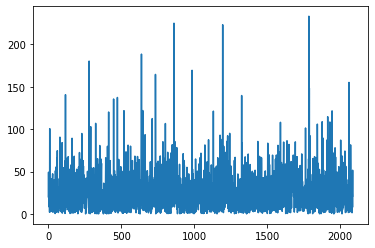

In [ ]:
# Añadimos un gráfico para visualizar el error medio absoluto, al igual
# que hicimos en el módulo de ML
plt.plot(range(y_pred.shape[0]), error_descaled)

El error medio obtenido, 26.65, es ligeramente mejor al obtenido en ML.

## 5.2 Modelos solo con imágenes
En este apartado vamos a seleccionar 512 características de cada imagen y las combinaremos con los datos del dataframe global.  Los modelos van a relacionar directamente las características extraídas de las imágenes con los precios de las viviendas. Dado que casi todas las viviendas son de Madrid y hay muy pocos registros sin precio, no vamos a realizar ningún tratamiento previo al dataset global *data_with_images*. Realmente lo que vamos a realizar en este apartado es tratar de relacionar imágenes de viviendas con su precio.

### 5.2.1 Carga de carácterísticas de imágenes desde GDrive
Esta epígrafe se ejecutará si ya tenemos en GDrive un archivo con las características de las imágenes. Este epígrafe es incompatible con el siguiente, el cual genera las características y las almacena en GDrive

In [ ]:
images_feat = np.load('/content/drive/My Drive/images_feat.npy')
print(images_feat.shape)

(11266, 512)


### 5.2.2 Extracción de características de imágenes y almacenamiento en GDrive
Este epígrafe se ejecutará si no se ha procesado el anterior. La características las vamos a obtener a partir de un modelo de VGG16 al que le vamos a aplicar una capa GlobalAveragePooling. Se presume que los resultados no serán buenos porque las imágenes de VGG16 no han sido entrenadas específicamente con fotos de viviendas, pero las características que obtengamos se supone que serán lo suficientemente buenas como para crear los modelos con imágenes. 

TODO: Lo ideal sería haber obtenido modelo especilizado en imágenes de estancias de viviendas. Esta tarea se deja para futuros estudios.

In [ ]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model_vgg16 = VGG16(weights='imagenet', include_top=False)

# creamos un modelo añadiéndole la capa GlobalAveragePooling
x = model_vgg16.output
gap = GlobalAveragePooling2D()(x)
model = Model(inputs=model_vgg16.input, outputs=gap)

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________________________________

In [ ]:
images.shape[0]

11266

In [ ]:
# vamos a procesarlas y a extraer el vector de 512 características
# TODO: Analizar la posibilidad de extraer menos características
n_images = images.shape[0]
images_feat = np.zeros((n_images, 512))

for i in tqdm(range(n_images)):
    img = images[i]
    aux = image.img_to_array(img)
    aux = np.expand_dims(aux, axis=0)
    aux = preprocess_input(aux)
    features = model.predict(aux)
    images_feat[i] = features[0]

100%|██████████| 11266/11266 [1:37:24<00:00,  1.93it/s]


In [ ]:
images_feat.shape

(11266, 512)

In [ ]:
# Para evitar repetir la extracción de features, las guardamos en un archivo
np.save('images_feat.npy', images_feat)

In [ ]:
!cp images_feat.npy /content/drive/My\ Drive/images_feat.npy

### 5.2.3 Clasificación

En este epígrafe vamos a proceder de forma similar a la clasificación realizada con sólo los datos numéricos y categóricos.

En primer lugar vamos crear la variable donde se almacena nuestra variable objetivo clasificada en tres clases.


In [ ]:
y_class = create_labels(data_with_images)
unique, counts = np.unique(y_class, return_counts=True)
dict(zip(unique, counts))

{0: 5411, 1: 5085, 2: 770}

In [ ]:
# Al igual que en el caso de datos numéricos y categóricos, vamos a normalizar los datos 
# de las características de las imágenes. En este caso podemos normilizar todos
# los datos a la vez, sin separar train de test porque no influye
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
images_scaled = min_max_scaler.fit_transform(images_feat)

In [ ]:
print(images_feat.shape)
print(images_scaled.shape)

(11266, 512)
(11266, 512)


In [ ]:
# Categorizamos la variable objetivo con OneHot
from keras.utils import to_categorical
y_class_onehot = to_categorical(y_class)

# Dividimos los datos en train y en test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_scaled, y_class_onehot, test_size=0.2, shuffle=True, random_state=0)
# Debido a que las clases de la variable objetivo no están balanceadas
# estratificamos los datos
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

In [ ]:
print(X_train.shape, y_train.shape)

(8110, 512) (8110, 3)


In [ ]:
print(X_test.shape, y_test.shape)

(2254, 512) (2254, 3)


In [ ]:
print(X_val.shape, y_val.shape)

(902, 512) (902, 3)


In [ ]:
# Creamos un modelo con la misma red neuronal que en el caso de clasificación
# de datos numéricos y categóricos
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)
#          batch_size=10)

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8110 samples, validate on 902 samples
Epoch 1/50
8110/8110 [==============================] - 2s 191us/step - loss: 0.9015 - accuracy: 0.4726 - val_loss: 0.8957 - val_accuracy: 0.4789
Epoch 2/50
8110/8110 [==============================] - 1s 170us/step - loss: 0.8917 - accuracy: 0.4797 - val_loss: 0.8997 - val_accuracy: 0.4778
Epoch 3/50
8110/8110 [==============================] - 1s 173us/step - loss: 0.8847 - accuracy: 0.4957 - val_loss: 0.9058 - val_accuracy: 0.4767
Epoch 4/50
8110/8110 [==============================] - 2s 186us/step - loss: 0.8760 - accuracy: 0.5153 - val_loss: 0.9055 - val_accuracy: 0.4678
Epoch 5/50
8110/8110 [==============================] - 1s 167us/step - loss: 0.8632 - accuracy: 0.5276 - val_loss: 0.9180 - val_accuracy: 0.4568
Epoch 6/50
8110/8110 [==============================] - 1s 174us/step - loss: 0.8492 - accuracy: 0.5446 - val_loss: 0.9227 - val_accuracy: 0.4612
Epoch 7/50
8110/8110 [==============================] - 1s 180us/step - loss:

Es bastante sospechoso un accuracy en train de 0.9761, casi 1. Esto da a entender que estamos teniendo muy posiblemente overfitting, esto es, el modelo está aprendiendo muy bien los datos de training y, por tanto, generalizará peor. Tal y como se vieron en los notebooks de clase, una de las soluciones posible es insertar capas de Dropout, las cuales eliminan neuronas aleatoriamente. Repetimos la red neuronal, pero insertando dos capas Dropout del 25% de eliminación de neuronas, con el fin de reducir el overfitting.

In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)
#          batch_size=10)

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')

Train on 8110 samples, validate on 902 samples
Epoch 1/50
8110/8110 [==============================] - 2s 220us/step - loss: 0.9150 - accuracy: 0.4633 - val_loss: 0.8935 - val_accuracy: 0.4845
Epoch 2/50
8110/8110 [==============================] - 2s 192us/step - loss: 0.9001 - accuracy: 0.4735 - val_loss: 0.8929 - val_accuracy: 0.4922
Epoch 3/50
8110/8110 [==============================] - 2s 193us/step - loss: 0.8951 - accuracy: 0.4731 - val_loss: 0.8941 - val_accuracy: 0.4812
Epoch 4/50
8110/8110 [==============================] - 2s 197us/step - loss: 0.8911 - accuracy: 0.4855 - val_loss: 0.8966 - val_accuracy: 0.4745
Epoch 5/50
8110/8110 [==============================] - 2s 190us/step - loss: 0.8880 - accuracy: 0.4804 - val_loss: 0.8966 - val_accuracy: 0.4767
Epoch 6/50
8110/8110 [==============================] - 2s 189us/step - loss: 0.8814 - accuracy: 0.4974 - val_loss: 0.9004 - val_accuracy: 0.4723
Epoch 7/50
8110/8110 [==============================] - 2s 191us/step - loss:

Hemos reducido ligeramente el accuracy de train, y por tanto el overfitting, pero sigue siendo alto. Hemos mejorado el accuracy de test, aunque prácticamente es igual. Se han tenido que realizar varias ejecuciones para conseguir un Acc de test algo mejor.

TODO: Deberíamos probar distintas combinaciones de capas y, por ejemplo, utilizar otras capas de Dropout con diferentes porcentajes de anulación de neuronas.

### 5.2.4 Regresión lineal
En este epígrafe crearemos un modelo con respecto a la variable objetivo precio, directamente, sin realizar clasificaciones.

Repetiremos parte de lo realizado en el proceso de clasificación

In [ ]:
# Escalamos los datos de las características de imágenes
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
images_scaled = min_max_scaler.fit_transform(images_feat)


In [ ]:
print(images_scaled.shape)

(11266, 512)


In [ ]:
# También debemos escalar los precios. En este caso vamos a 
# realizarlo manualmente, teniendo en cuentas los 
# precios máximo y mínimo
precio_maximo = data_with_images['Price'].max()
precio_minimo = data_with_images['Price'].min()
print(precio_maximo, precio_minimo)

875.0 9.0


In [ ]:
y_reg =  data_with_images['Price']
y_scaled = (y_reg - precio_minimo) / (precio_maximo - precio_minimo)
print(y_scaled.shape)

(11266,)


In [ ]:
y_scaled.isna().sum()

0

In [ ]:
# Dividimos train, validation y test de forma similar a como lo hecho en
# clasificación, pero sin estratificar. Lo ideal sería convertir la
# variable objetivo a su logaritmo.
# TODO: Analizar resultados con el logaritmo del precio.

# Dividimos los datos en train y en test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_scaled, y_scaled, test_size=0.2, shuffle=True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)


In [ ]:
# Creamos el modelo de forma similar a clasificación, pero sustituyendo la última
# capa de salida única y ajustando la función de pérdidas
# y optimación a las regresiones lineales
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='RMSProp')

history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)
#          batch_size=10)

loss = model.evaluate(X_test, y_test)
print(f'Loss={loss}')


Train on 8110 samples, validate on 902 samples
Epoch 1/50
8110/8110 [==============================] - 2s 193us/step - loss: 0.0068 - val_loss: 0.0043
Epoch 2/50
8110/8110 [==============================] - 1s 165us/step - loss: 0.0064 - val_loss: 0.0041
Epoch 3/50
8110/8110 [==============================] - 1s 165us/step - loss: 0.0064 - val_loss: 0.0042
Epoch 4/50
8110/8110 [==============================] - 1s 165us/step - loss: 0.0064 - val_loss: 0.0042
Epoch 5/50
8110/8110 [==============================] - 1s 171us/step - loss: 0.0064 - val_loss: 0.0043
Epoch 6/50
8110/8110 [==============================] - 1s 165us/step - loss: 0.0064 - val_loss: 0.0041
Epoch 7/50
8110/8110 [==============================] - 1s 173us/step - loss: 0.0064 - val_loss: 0.0041
Epoch 8/50
8110/8110 [==============================] - 1s 165us/step - loss: 0.0063 - val_loss: 0.0043
Epoch 9/50
8110/8110 [==============================] - 1s 162us/step - loss: 0.0063 - val_loss: 0.0042
Epoch 10/50
8110/

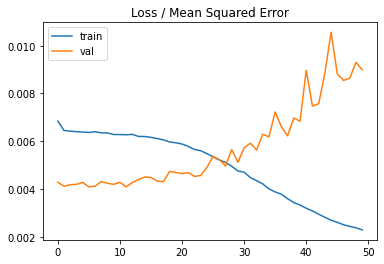

In [ ]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Se observa que si bien el error en train diminuye, el de validación sube. Definitivamente, el modelo está aprendiendo "de memoria" los datos. Las imágenes que estamos utilizando, al menos las características que estamos extrayendo de ellas, no sirven para predecir precios.

## 5.3 Modelos con datos numéricos, categóricos e imágenes

En este apartado vamos a repetir los cálculos anteriores pero con los datos totalmente fusionados.

In [ ]:
data_with_images.shape

(11266, 89)

In [ ]:
images_feat.shape

(11266, 512)

In [ ]:
# Convertir el array de features de las imágenes en un dataframe
df_image_feat = pd.DataFrame(images_feat)
df_image_feat.shape

(11266, 512)

In [ ]:
df_image_feat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,5.759094,2.522900,1.751382,0.005821,1.198743,1.087520,9.473874,0.922757,0.158611,1.668453,0.000000,1.988754,0.734030,0.0,0.000000,2.935021,0.000000,1.521513,1.573906,1.096696,2.205756,1.058890,2.877224,0.036967,6.680227,2.406163,4.536645,1.317740,2.342150,0.647398,1.027554,0.300906,1.871067,0.103010,2.244610,0.000000,6.242658,2.971969,0.000000,0.938305,0.000000,0.186956,4.630583,1.489258,16.143564,5.841228,1.007021,0.608276,0.043280,0.465724,1.193736,3.593384,2.170541,0.360971,0.061654,7.137065,0.000000,0.000000,1.983670,1.576604,2.192853,0.522403,3.650882,4.554504,0.000000,0.000000,0.730971,2.224573,8.576464,0.000000,0.596817,8.016862,0.040887,6.739801,1.911635,4.128465,0.083766,15.686258,3.323645,0.755304,0.0,5.689340,1.207282,0.303407,0.0,0.158356,0.592248,0.000000,0.000000,6.427669,0.0,0.000000,3.216933,2.26487,0.000000,8.348506,0.000000,0.480848,1.248600,1.876574,0.070724,16.351271,0.000000,2.109543,2.331443,0.471152,0.020548,0.305467,2.296829,0.000000,1.408191,0.000000,2.242615,6.327551,1.900127,0.689779,0.319541,4.589105,1.887962,1.062055,3.503059,1.914770,0.000000,0.000000,0.000000,2.286727,0.0,0.579215,1.374663,0.978836,0.916714,0.201635,0.000000,0.000000,4.001562,0.0,8.755240,0.000000,0.366305,0.819098,7.619056,0.0,0.416718,0.196855,8.388453,0.0,2.003638,1.430219,0.480041,0.000000,2.912714,0.0,13.850005,0.010969,0.134056,8.953253,0.000000,0.000000,0.0,0.494709,0.000000,0.036598,4.078772,6.201901,0.000000,0.543810,0.000000,0.000000,0.688812,1.122820,2.055202,0.000000,0.380590,27.224953,0.000000,16.841768,2.625572,0.999165,8.934770,2.316196,0.976042,0.518032,0.745153,1.851411,4.830136,0.020368,4.046648,0.000000,1.022079,0.0,0.057671,0.052501,0.598328,0.389802,13.032157,0.000000,6.569335,2.037841,0.776356,0.0,0.0,2.684600,0.134327,0.682136,1.913080,1.348109,2.126789,7.566365,0.000000,0.699015,3.497744,1.060943,0.000000,2.135506,0.540977,1.620152,2.892708,15.982737,6.091375,3.254059,0.000000,4.411687,0.879320,0.021264,0.000000,0.610258,0.746702,9.428549,1.709448,2.333486,0.562048,2.844979,6.762749,0.000000,0.000000,2.

In [ ]:
# Vamos a concaternar el daframe de datos completo con el dataframe de características/features de imágenes.
# Debemos tener en cuenta que esta operación pandas la realiza enlazando los index de las filas
# Debido a que el dataframe data_with_images lo hemos obtenido borrando y transformando
# dataframes originales, es lógico esperar que el index de las filas no se consecutivo
# y haya huecos.
# Esto circunstancia se comprueba fácilmente examinando los últimos registros
# del dataframe. Podemos observar que el index último es mayor que el número de filas
# total y que los números no son consecutivos, ya que hay huecos.
data_with_images.tail(5)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
13991,6608827,https://www.airbnb.com/rooms/6608827,20170407214119,2017-04-08,Estudio precioso y luminoso,"Estudio tipo loft en Lavapiés, junto a la plaz...",NaN,"Estudio tipo loft en Lavapiés, junto a la plaz...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://public.opendatasoft.com/api/v2/catalog...,NaN,34580491,https://www.airbnb.com/users/show/34580491,Iñigo,2015-05-30,"Madrid, Community of Madrid, Spain",NaN,within a day,90.0,NaN,https://a0.muscache.com/im/pictures/ab072bff-c...,https://a0.muscache.com/im/pictures/ab072bff-c...,Embajadores,1.0,1.0,"email,phone,reviews,jumio","Embajadores, Madrid, Comunidad de Madrid 28012...",Embajadores,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,40.408141,-3.701127,Apartment,Entire home/apt,2,1.0,0.0,2.0,Real Bed,"Wireless Internet,Kitchen,Family/kid friendly,...",NaN,100.0,363.0,1250.0,NaN,NaN,2,20,1,1125,9 months ago,NaN,27,57,87,362,2017-04-07,31,2015-06-01,2016-06-22,84.0,9.0,7.0,9.0,9.0,9.0,8.0,NaN,NaN,flexible,1,1.37,"40.4081410057,-3.70112666495","Host Has Profile Pic,Host Identity Verified,Is..."
13992,5278909,https://www.airbnb.com/rooms/5278909,20170407214119,2017-04-08,COZY APARTAMENT OLIVAR,"Estudio acogedor con un salón, dormitorio en a...",NaN,On foot.,none,NaN,NaN,On foot.,NaN,NaN,Parties forbiden.,NaN,NaN,https://public.opendatasoft.com/api/v2/catalog...,NaN,27326529,https://www.airbnb.com/users/show/27326529,Luis,2015-02-06,"Madrid, Community of Madrid, Spain",NaN,within a few hours,94.0,NaN,https://a0.muscache.com/im/pictures/f6f86010-3...,https://a0.muscache.com/im/pictures/f6f86010-3...,NaN,4.0,4.0,"email,phone,reviews,jumio,government_id","Madrid, Comunidad de Madrid 28012, Spain",NaN,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,40.409012,-3.699053,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",NaN,50.0,NaN,2200.0,150.0,40.0,2,10,2,1125,3 weeks ago,NaN,0,6,36,311,2017-04-07,20,2015-02-23,2017-01-02,92.0,9.0,9.0,9.0,10.0,9.0,9.0,NaN,NaN,strict,2,0.77,"40.4090122871,-3.6990527175","Host Has Profile Pic,Host Identity Verified,Re..."
13993,7701883,https://www.airbnb.com/rooms/7701883,20170407214119,2017-04-08,Apartment two travellers or couples,Luminous exterior apartment in the city center...,A very bright exterior apartment,Luminous exterior apartment in the city center...,none,Céntrico barrio con mucha actividad cultural y...,A 3 min de metro lavapies. Parkin público en c...,5min Lavapies Underground,Full apartament.,I will gladly receive you on your arrival and ...,**************Checkin / Checkout ************...,https://a0.muscache.com/im/pictures/a5828af5-6...,https://a0.muscache.com/im/pictures/a5

In [ ]:
# Reindexamos el dataframe de datos con imágenes antes de contatenar el data frame de características de imágenes
data_reindexed  = data_with_images.reset_index(drop=True)

In [ ]:
# Creamos un dataset concatenados los datos numéricos y 
# categóricos con las características de las imágenes.
# Podemos realizar esta concatenación porque sabemos el dataframe images_feat
# se ha creado en el mismo orden en el que están las filas del dataframe
# completo, una vez indexado, data_reindexed
full_data = pd.concat((data_reindexed, df_image_feat), axis=1)
print(full_data.shape)

(11266, 601)


A continuación, vamos a proceder del mismo modo que se ha hecho con el estudio de los datos numéricos y categóricos. Dividiremos los datos en train y test y les aplicaremos las trasnformaciones necesarias. Al igual que en el apartado 5.1 solo se van a estudiar los datos de Madrid.

In [ ]:
# Separamos train y test
train, test = train_test_split(full_data, test_size=0.2, shuffle=True, random_state=0)
print(train.shape, test.shape)

(9012, 601) (2254, 601)


In [ ]:
# Aplicamos las transformaciones a train
train = drop_columns_and_filter_rows_in_test_set(train 
    , mean_Bathrooms, mean_Bedrooms, mean_Beds, mean_Review_Scores_Value
    , mode_Host_Response_Time, mean_price_map, overall_mean_price)
print(train.shape)

(8352, 538)


In [ ]:
# Recalculamos correctamente las medias y modas ya que hemos utilizado
# los datos anteriores que corresponde a otra división en la que se ha aplicado
# shuffle y por tanto no tiene por qué ser los mismos

# Medias para sustituir valores nulos
mean_Bathrooms = train['Bathrooms'].mean()
mean_Bedrooms = train['Bedrooms'].mean()
mean_Beds = train['Beds'].mean()
mean_Review_Scores_Value = train['Review Scores Value'].mean()
print (f'Media de baños {mean_Bathrooms}')
print (f'Media de habitaciones {mean_Bedrooms}')
print (f'Media de camas {mean_Beds}')
print (f'Media de puntaciones {mean_Review_Scores_Value}')

train = fillna_with_means(train, mean_Bathrooms, mean_Bedrooms, mean_Beds
    , mean_Review_Scores_Value)

Media de baños 1.2354635297452567
Media de habitaciones 1.2727489847409188
Media de camas 1.9441434110613713
Media de puntaciones 9.216851038035825


In [ ]:
# Moda para sustituir valores nulos
mode_Host_Response_Time = train["Host Response Time"].mode()[0]
train = fillna_Host_Response_Time_with_its_mode(train, mode_Host_Response_Time)

In [ ]:
# Calculamos precios medios por cada categoría dentro de cada variable categórica
# Almacenamos los precios medios para su uso posterior
for var in get_categorical_variables():
    mean_price_map[var] = train.groupby(var)['Price'].mean()

# Guardamos el precio medio general por si en test hay variables categóricas que no están en train
# En este tipo de casos es bastante común hacer medias de medias, pero en el nuestro, hemos preferido utilizar el precio medio
# general, porque no hay mucha diferencia.
overall_mean_price = train['Price'].mean()    

# Asignamos    
train = mean_encoding_to_categorical_variables(train, mean_price_map, overall_mean_price)

In [ ]:
# Aplicamos las mismas transformaciones a test
test = drop_columns_and_filter_rows_in_test_set(test 
    , mean_Bathrooms, mean_Bedrooms, mean_Beds, mean_Review_Scores_Value
    , mode_Host_Response_Time, mean_price_map, overall_mean_price)
print(test.shape)

(2088, 538)


In [ ]:
# Creamos las variables objetivo de tipo clase de train y test
y_train_class = create_labels(train)
y_test_class = create_labels(test)

### 5.3.1 Clasificación

In [ ]:
# Utilizamos los datos del dataframe, menos el precio

data = train.values

X_train = data[:,1:]      # nos quedamos con todas las columnas menos el precio


In [ ]:
# Normalizamos los datos de train (valores entre 0 y 1). 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
XtrainScaled = min_max_scaler.fit_transform(X_train)

In [ ]:
XtrainScaled.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
# Aplicamos OneHot a la variable objetivo
from keras.utils import to_categorical

y_training_class_onehot = to_categorical(y_train_class)


In [ ]:
# Para crear el modelo debemos dividir el dataset de train, en train y validation
# Como ya sabemos por los procesos anteriores, los precios no están correctamente
# distribuidos. Por esa razón, vamos a estratificar para que los dataset
# obtenidos para los modelos estén balanceados en la medida de lo posible
X_train, X_val, y_train, y_val = train_test_split(XtrainScaled, y_training_class_onehot
                  , test_size=0.1, random_state=0, stratify=y_training_class_onehot)

In [ ]:
# Creamos modelo de calsificación con tres capas densas
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Asignamos el valor 3, porque tenemos 3 clases

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)
#          batch_size=10)

Train on 7516 samples, validate on 836 samples
Epoch 1/50
7516/7516 [==============================] - 2s 203us/step - loss: 0.5819 - accuracy: 0.7690 - val_loss: 0.4871 - val_accuracy: 0.8002
Epoch 2/50
7516/7516 [==============================] - 2s 201us/step - loss: 0.4829 - accuracy: 0.8043 - val_loss: 0.4911 - val_accuracy: 0.8038
Epoch 3/50
7516/7516 [==============================] - 1s 181us/step - loss: 0.4542 - accuracy: 0.8151 - val_loss: 0.4649 - val_accuracy: 0.8026
Epoch 4/50
7516/7516 [==============================] - 1s 181us/step - loss: 0.4322 - accuracy: 0.8199 - val_loss: 0.4763 - val_accuracy: 0.8110
Epoch 5/50
7516/7516 [==============================] - 1s 181us/step - loss: 0.4142 - accuracy: 0.8309 - val_loss: 0.4710 - val_accuracy: 0.8074
Epoch 6/50
7516/7516 [==============================] - 1s 184us/step - loss: 0.3928 - accuracy: 0.8332 - val_loss: 0.4878 - val_accuracy: 0.8134
Epoch 7/50
7516/7516 [==============================] - 1s 189us/step - loss:

In [ ]:
# A continuación debemos escalar test del mismo modo que train
data_test = test.values
X_test = data_test[:,1:]  # nos quedamos con todas las columnas menos el precio
# Escalamos test
XtestScaled = min_max_scaler.fit_transform(X_test)
# Transformamos a OneHot la clase de test
y_test_class_onehot = to_categorical(y_test_class)


In [ ]:
loss, acc = model.evaluate(XtestScaled, y_test_class_onehot)
print(f'Loss={loss}, Acc={acc}')

2088/2088 [==============================] - 0s 28us/step
Loss=8.13186645873205, Acc=0.5718390941619873


Se observa que hemos obtenido un accurracy 0.5718 inferior al que hemos obtenido cuando no hemos tenido en cuenta las características de las imágenes, 0.7978. Las imágenes no ayudan con la clasificación.


Con el fin de mejorar algo, en esta ocasión vamos a repetir la creación del modelo añadiendo capas DropOut y, además, regularización L1.

In [ ]:
# Creamos modelo de clasificación con tres capas densas con regularización L1 y
# dos DropOt
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1(0.003)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))  # Asignamos el valor 3, porque tenemos 3 clases

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)
#          batch_size=10)

loss, acc = model.evaluate(XtestScaled, y_test_class_onehot)
print(f'Loss={loss}, Acc={acc}')

Train on 7516 samples, validate on 836 samples
Epoch 1/50
7516/7516 [==============================] - 2s 251us/step - loss: 1.4422 - accuracy: 0.7326 - val_loss: 0.7312 - val_accuracy: 0.7978
Epoch 2/50
7516/7516 [==============================] - 2s 212us/step - loss: 0.7269 - accuracy: 0.7907 - val_loss: 0.7001 - val_accuracy: 0.7978
Epoch 3/50
7516/7516 [==============================] - 2s 210us/step - loss: 0.6979 - accuracy: 0.7956 - val_loss: 0.6583 - val_accuracy: 0.7978
Epoch 4/50
7516/7516 [==============================] - 2s 208us/step - loss: 0.6837 - accuracy: 0.7979 - val_loss: 0.6531 - val_accuracy: 0.7978
Epoch 5/50
7516/7516 [==============================] - 2s 209us/step - loss: 0.6783 - accuracy: 0.7970 - val_loss: 0.6454 - val_accuracy: 0.7978
Epoch 6/50
7516/7516 [==============================] - 2s 207us/step - loss: 0.6717 - accuracy: 0.7996 - val_loss: 0.6417 - val_accuracy: 0.7978
Epoch 7/50
7516/7516 [==============================] - 2s 208us/step - loss:

Tampoco mejoramos. Habría que hacer más combinaciones, pero lo que realmente hay que conseguir son mejores features de imágenes.

### 5.3.2 Regresión lineal

In [ ]:
# Repetimos las mismas operaciones realizadas en la regresión lineal de
# solo datos numéricos y categóricos 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

data = train.values
data_scaled = min_max_scaler.fit_transform(data)
y_scaled_train = data_scaled[:,0:1]     # En la 1ª columna está Price, nuestra variable objetivo
X_scaled_train = data_scaled[:,1:] # Resto de columnas

In [ ]:
X_scaled_train.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled_train, y_scaled_train
                  , test_size=0.1, random_state=0)

In [ ]:
# Repetimos las declaraciones, aunque ya están importadas en pasos anteriores
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # En este caso solo es una neurona porque solo tenemos una salida: directamente el precio

# Utilizamos funciones loss y optimizer acordes con la regresión lineal
model.compile(loss='mean_squared_error', optimizer='RMSProp')

history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=8)

Train on 7516 samples, validate on 836 samples
Epoch 1/50
7516/7516 [==============================] - 2s 219us/step - loss: 0.0124 - val_loss: 0.0138
Epoch 2/50
7516/7516 [==============================] - 1s 179us/step - loss: 0.0097 - val_loss: 0.0113
Epoch 3/50
7516/7516 [==============================] - 1s 182us/step - loss: 0.0089 - val_loss: 0.0102
Epoch 4/50
7516/7516 [==============================] - 1s 185us/step - loss: 0.0085 - val_loss: 0.0099
Epoch 5/50
7516/7516 [==============================] - 1s 189us/step - loss: 0.0081 - val_loss: 0.0102
Epoch 6/50
7516/7516 [==============================] - 1s 191us/step - loss: 0.0078 - val_loss: 0.0101
Epoch 7/50
7516/7516 [==============================] - 1s 180us/step - loss: 0.0074 - val_loss: 0.0107
Epoch 8/50
7516/7516 [==============================] - 1s 180us/step - loss: 0.0072 - val_loss: 0.0096
Epoch 9/50
7516/7516 [==============================] - 1s 186us/step - loss: 0.0068 - val_loss: 0.0099
Epoch 10/50
7516/

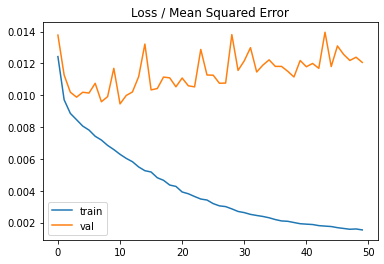

In [ ]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Se confirma más todavía que las imágenes no ayudan en nada a la predicción del precio.

In [ ]:
# Normalizamos los datos de test (valores entre 0 y 1). 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_test = test.values
data_test_scaled = min_max_scaler.fit_transform(data_test)
y_scaled_test = data_test_scaled[:,0:1]  # En la 1ª columna está Price, nuestra variable objetivo
X_scaled_test = data_test_scaled[:,1:] # Resto de columnas

In [ ]:
X_scaled_test.max(axis=0)

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
loss = model.evaluate(X_scaled_test, y_scaled_test)
print(f'Loss={loss}')

2088/2088 [==============================] - 0s 36us/step
Loss=0.037447664230148454


In [ ]:
# Vamos a calcular el error medio absoluto manualmente
# Para ello lo primero que debemos hacer es desnormalizar los datos
precio_maximo = data_test[:,0:1].max()
precio_minimo = data_test[:,0:1].min()
print(precio_maximo, precio_minimo)

300.0 10.0


In [ ]:
y_pred = model.predict(X_scaled_test)
y_pred_descaled = y_pred[:, 0] * (precio_maximo - precio_minimo) + precio_minimo
y_test_descaled = y_scaled_test[:, 0] * (precio_maximo - precio_minimo) + precio_minimo
error_descaled = np.abs(y_pred_descaled - y_test_descaled)
print(f'Error medio absoluto: {error_descaled.mean()}')

Error medio absoluto: 38.808983513678626


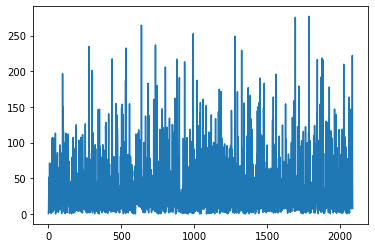

In [ ]:
# Añadimos un gráfico para visualizar el error medio absoluto, al igual
# que hicimos en el módulo de ML
plt.plot(range(y_pred.shape[0]), error_descaled)

Se vuelve a confirmar, también en regresión, que añadiendo el análisis de imágenes, los datos obtenidos son peores.

# 6 Conclusiones

- Se ha observado que, en este caso, las redes neuronales funcionan ligeramente mejor que el machine learning, al menos, aplicando las mismas conversiones y transformaciones.
- La VGG16 utilizada para la extracción de características de las imágenes de Tumbnail de las viviendas no son correctas o no proprocionan la suficiente información. 
- A lo largo del notebook se han indicado tareas por realizar (TODOs), que deberían realizarse. Algunas de ellas son:
    - En el EDA
    	- Analizar palabras clave en textos de algunas columnas y relacionarlas con el precio. 
    	- También estudiar más detenidamente Cleaning Fee.
    	- Analizar qué valores de Amenities y otras columnas pueden influir sobre el precio.
    - Estructurar información de imágenes separando e identificando estancias como cocina, salón, baño, dormitorio, etc.
    - Realizar una mejor extracción de características de imágenes. Intentar reducir el vector a menos de 512. Hacer pruebas con distintos tamaños.
    - Realizar distintas combinaciones de tipos de capas y regularizaciones. Sólo se han hecho capas DropOut y regularización L1. También deberían hacerse más pruebas con estas capas y regularización.
    - Debido a que el precio no está balanceado, analizar los datos con el logaritmo del precio.
